# Project: Identify Customer Segments

### By: Ken Norton

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn import preprocessing, decomposition
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

# magic word for producing visualizations in notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
%load_ext autoreload
%autoreload 2

In [2]:
# Plot styles
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-poster')

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# NOTE: the terms of use prevent me from including these files in the repo

# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print('azdias: ', azdias.shape)
print('feat_info: ', feat_info.shape)

azdias:  (891221, 85)
feat_info:  (85, 4)


In [5]:
azdias.head()

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  GEBURTSJAHR  \
0                      5                 3          4            0   
1                      4                 5          1         1996   
2                      3                 5          1         1979   
3                      1                 2          6         1957   
4                      3                 2          5         1963   

   GFK_URLAUBERTYP  GREEN_AVANTGARDE  HEALTH_TYP  LP_LEBENSPHASE_FEIN  \
0             10.0                 0          -1                 15.0   
1             10.0                 0           3                 21.0   
2             10.0                 1           3                  3.0   
3              1.0                 0           2                  0.0   
4              5.0                 0           3                 32.0   

   LP_LEBENSPHASE_GROB  LP_FAMILIE_FEIN  LP_FAMILIE_GROB  LP_STATUS_FEIN  \
0                  4.0              2.0              2.0             1.0   
1                  6.0              5.0              3.0             2.0   
2                  1.0              1.0              1.0             3.0   
3                  0.0              0.0              0.0             9.0   
4                 10.0             10.0              5.0             3.0   

   LP_STATUS_GROB  NATIONALITAET_KZ  PRAEGENDE_JUGENDJAHRE  RETOURTYP_BK_S  \
0             1.0                 0                      0             5.0   
1             1.0                 1                     14             1.0   
2             2.0                 1                     15             3.0   
3             4.0                 1                      8             2.0   
4             2.0                 1                      8             5.0   

   SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  \
0          2          6          7          5           1           5   
1          5          4          4          3           1           2   
2          4          1          3          3           4           4   
3          5          1          2          1           4           4   
4          6          4          4          2           7           4   

   SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  \
0          3           3          4           7          6           6   
1          2           3          6           4          7           4   
2          6           3          4           7          7           7   
3          7           4          3           4          4           5   
4          4           6          2           3          2           2   

   SEMIO_PFLICHT  SEMIO_TRADV  SHOPPER_TYP  SOHO_KZ  TITEL_KZ  VERS_TYP  \
0              5            3           -1      NaN       NaN        -1   
1              7            6            3      1.0       0.0         2   
2              3            3            2      0.0       0.0         1   
3              4            4            1      0.0       0.0         1   
4              4            2            2      0.0       0.0         2   

   ZABEOTYP  ALTER_HH  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCO

In [6]:
feat_info

attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numeric                [0]
12        GFK_URLAUBERTYP            person  categorical                 []
13       GREEN_AVANTGARDE            person  categorical                 []
14             HEALTH_TYP            person      ordinal             [-1,0]
15    LP_LEBENSPHASE_FEIN            person        mixed                [0]
16    LP_LEBENSPHASE_GROB            person        mixed                [0]
17        LP_FAMILIE_FEIN            person  categorical                [0]
18        LP_FAMILIE_GROB            person  categorical                [0]
19         LP_STATUS_FEIN            person  categorical                [0]
20         LP_STATUS_GROB            person  categorical                [0]
21       NATIONALITAET_KZ            person  categorical             [-1,0]
22  PRAEGENDE_JUGENDJAHRE            person        mixed             [-1,0]
23         RETOURTYP_BK_S            person      ordinal                [0]
24              SEMIO_SOZ            person      ordinal             [-1,9]
25              SEMIO_FAM            person      ordinal             [-1,9]
26              SEMIO_REL            person      ordinal             [-1,9]
27              SEMIO_MAT            person      ordinal             [-1,9]
28             SEMIO_VERT            person      ordinal             [-1,9]
29             SEMIO_LUST            person      ordinal             [-1,9]
30              SEMIO_ERL            person      ordinal             [-1,9]
31             SEMIO_KULT            person      ordinal             [-1,9]
32              SEMIO_RAT            person      ordinal             [-1,9]
33             SEMIO_KRIT            person      ordinal             [-1,9]
34              SEMIO_DOM            person      ordinal             [-1,9]
35             SEMIO_KAEM            person      ordinal             [-1,9]
36          SEMIO_PFLICHT            person      ordinal             [-1,9]
37            SEMIO_TRADV            person      ordinal             [-1,9]
38            SHOPPER_TYP            person  categorical               [-1]
39                SOHO_KZ            person  categorical               [-1]
40               TITEL_KZ            person  categorical             [-1,0]
41               VERS_TYP            person  categorical               [-1]
42               ZABEOTYP            person  categorical             [-1,9]
43               ALTER_HH         household     interval                [0]
44           ANZ_PERSONEN         household      numeric                 []
45              ANZ_TITEL         household      numeric                 []
46     HH_EINKOMMEN_SCORE         household      ordinal             [-1,0]
47           KK_KUNDENTYP         household  categorical               [-1]
48         W_KEIT_KIND_HH         household      ordinal             [-1,0]
49         WOHNDAUER_2008         household      ordinal             [-1,0]
50    ANZ_HAUSHALTE_AKTIV          building      numeric                [0]
51           ANZ_HH_TITEL          building      numeric        

In [7]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
df_clean = azdias.copy()

In [9]:
df_clean.dtypes

AGER_TYP                   int64
ALTERSKATEGORIE_GROB       int64
ANREDE_KZ                  int64
CJT_GESAMTTYP            float64
FINANZ_MINIMALIST          int64
FINANZ_SPARER              int64
FINANZ_VORSORGER           int64
FINANZ_ANLEGER             int64
FINANZ_UNAUFFAELLIGER      int64
FINANZ_HAUSBAUER           int64
FINANZTYP                  int64
GEBURTSJAHR                int64
GFK_URLAUBERTYP          float64
GREEN_AVANTGARDE           int64
HEALTH_TYP                 int64
LP_LEBENSPHASE_FEIN      float64
LP_LEBENSPHASE_GROB      float64
LP_FAMILIE_FEIN          float64
LP_FAMILIE_GROB          float64
LP_STATUS_FEIN           float64
LP_STATUS_GROB           float64
NATIONALITAET_KZ           int64
PRAEGENDE_JUGENDJAHRE      int64
RETOURTYP_BK_S           float64
SEMIO_SOZ                  int64
SEMIO_FAM                  int64
SEMIO_REL                  int64
SEMIO_MAT                  int64
SEMIO_VERT                 int64
SEMIO_LUST                 int64
SEMIO_ERL 

In [10]:
feat_info[feat_info.missing_or_unknown.str.contains('X')]

attribute information_level         type missing_or_unknown
57  CAMEO_DEUG_2015     microcell_rr4  categorical             [-1,X]
58   CAMEO_DEU_2015     microcell_rr4  categorical               [XX]
59  CAMEO_INTL_2015     microcell_rr4        mixed            [-1,XX]

In [11]:
# Test one of the columns, we see string values here
df_clean.CAMEO_DEUG_2015.unique()

array([nan, '8', '4', '2', '6', '1', '9', '5', '7', '3', 'X'],
      dtype=object)

In [12]:
# Identify missing or unknown data values and convert them to NaNs.
df_clean.loc[df_clean['CAMEO_DEUG_2015'] == 'X'] = np.nan
df_clean.loc[df_clean['CAMEO_DEU_2015'] == 'XX'] = np.nan
df_clean.loc[df_clean['CAMEO_INTL_2015'] == 'XX'] = np.nan

# Now convert two of the columns to numeric since strings are gone, keep _DEU_ as string
df_clean['CAMEO_DEUG_2015'] = pd.to_numeric(df_clean['CAMEO_DEUG_2015'], errors='coerce')
df_clean['CAMEO_INTL_2015'] = pd.to_numeric(df_clean['CAMEO_INTL_2015'], errors='coerce')

In [13]:
# Let's retest that column, expect to see integers!
df_clean.CAMEO_DEUG_2015.unique()

array([nan,  8.,  4.,  2.,  6.,  1.,  9.,  5.,  7.,  3.])

In [14]:
# Iterate over the feat_info df - this is not the most efficient
# way to do it, and I'd like to try to handle the string values
# in one single for-loop as an improvement
for index, row in feat_info.iterrows():
    attr = row['attribute']
    # Strip out the brackets and separate on comma
    values = row['missing_or_unknown'].replace('[', '').replace(']',
                                                                '').split(',')
    for val in values:
        # We still have strings in here (X / XX) so ignore them
        if val not in ['', 'X', 'XX']:
            val = int(val)
            df_clean.loc[df_clean[attr] == val, attr] = np.nan

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [15]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
# Thanks StackOverflow: https://stackoverflow.com/a/51071037
percent_missing = df_clean.isnull().sum() * 100 / len(df_clean)
missing_values = pd.DataFrame({
    'column_name': df_clean.columns,
    'percent_missing': percent_missing
})

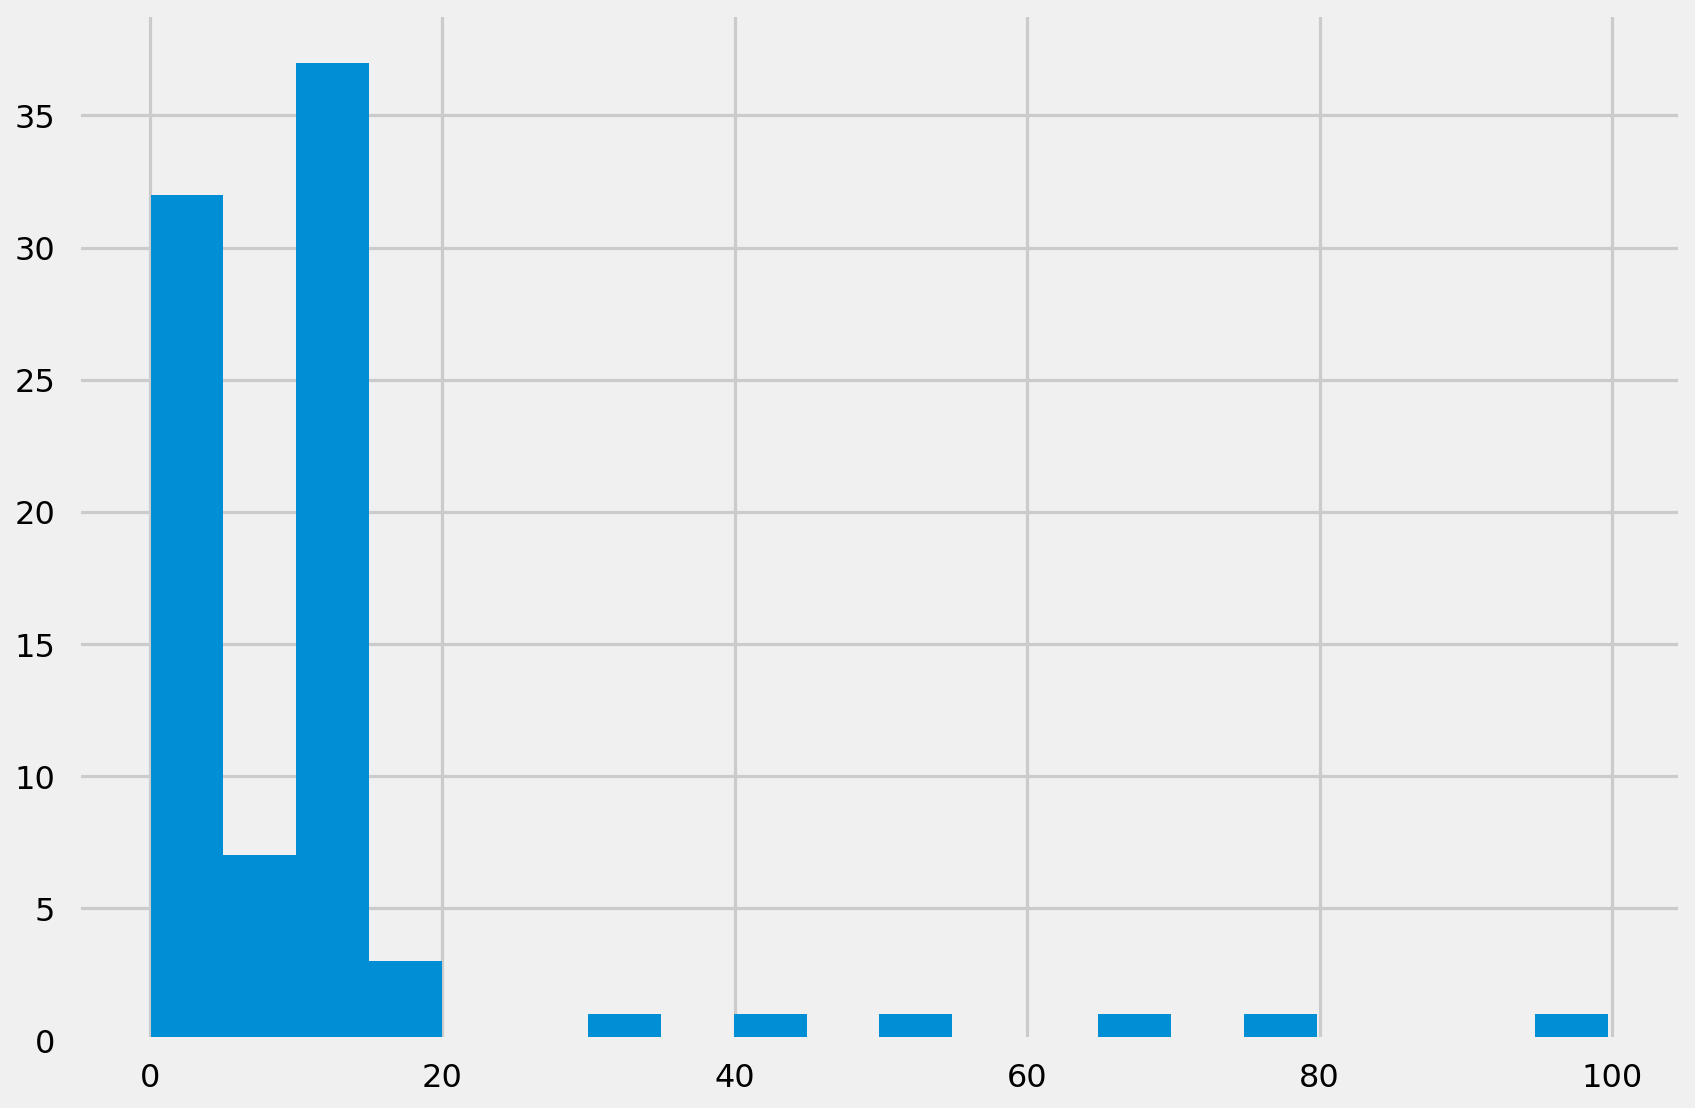

In [16]:
# Investigate patterns in the amount of missing data in each column.

plt.hist(missing_values['percent_missing'], bins=20)
plt.show()

In [17]:
missing_values.sort_values(by='percent_missing', ascending=False).head(25)

column_name  percent_missing
TITEL_KZ              TITEL_KZ        99.757636
AGER_TYP              AGER_TYP        76.963739
KK_KUNDENTYP      KK_KUNDENTYP        65.620312
KBA05_BAUMAX      KBA05_BAUMAX        53.485387
GEBURTSJAHR        GEBURTSJAHR        44.049007
ALTER_HH              ALTER_HH        34.842312
KKK                        KKK        17.769218
REGIOTYP              REGIOTYP        17.769218
W_KEIT_KIND_HH  W_KEIT_KIND_HH        16.640990
KBA05_ANTG1        KBA05_ANTG1        14.992802
KBA05_ANTG2        KBA05_ANTG2        14.992802
KBA05_ANTG3        KBA05_ANTG3        14.992802
KBA05_ANTG4        KBA05_ANTG4        14.992802
KBA05_GBZ            KBA05_GBZ        14.992802
MOBI_REGIO          MOBI_REGIO        14.992802
PLZ8_ANTG3          PLZ8_ANTG3        13.109655
PLZ8_ANTG2          PLZ8_ANTG2        13.109655
PLZ8_GBZ              PLZ8_GBZ        13.109655
PLZ8_HHZ              PLZ8_HHZ        13.109655
PLZ8_ANTG1          PLZ8_ANTG1        13.109655
PLZ8_BAUMAX        PLZ8_BAUMAX        13.109655
PLZ8_ANTG4          PLZ8_ANTG4        13.109655
VERS_TYP              VERS_TYP        12.515975
HEALTH_TYP          HEALTH_TYP        12.515975
SHOPPER_TYP        SHOPPER_TYP        12.515975

Several of our columns have >50% missing values. Looking at them, they are:

* `TITEL_KZ` Academic title flag
* `AGER_TYP` Best-ager typology
* `KK_KUNDENTYP` Consumer pattern over past 12 months
* `KBA05_BAUMAX` Most common building type within the microcell
* `GEBURTSJAHR` Year of birth

Let's drop all of these columns.

In [18]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

df_clean = df_clean.drop(
    columns=['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR'])


#### Discussion 1.1.2: Assess Missing Data in Each Column

I decided to remove any column that didn't have at least 50% coverage. The columns I removed were:

* `TITEL_KZ` Academic title flag
* `AGER_TYP` Best-ager typology
* `KK_KUNDENTYP` Consumer pattern over past 12 months
* `KBA05_BAUMAX` Most common building type within the microcell
* `GEBURTSJAHR` Year of birth

Some of them seem like they would have been useful (such as consumer pattern and year of birth), but potentially the present values could be biased. For example, it's possible older respondents reported their year of birth but younger respondents did not. With >50% missing values, it's best to just remove the data from analysis.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

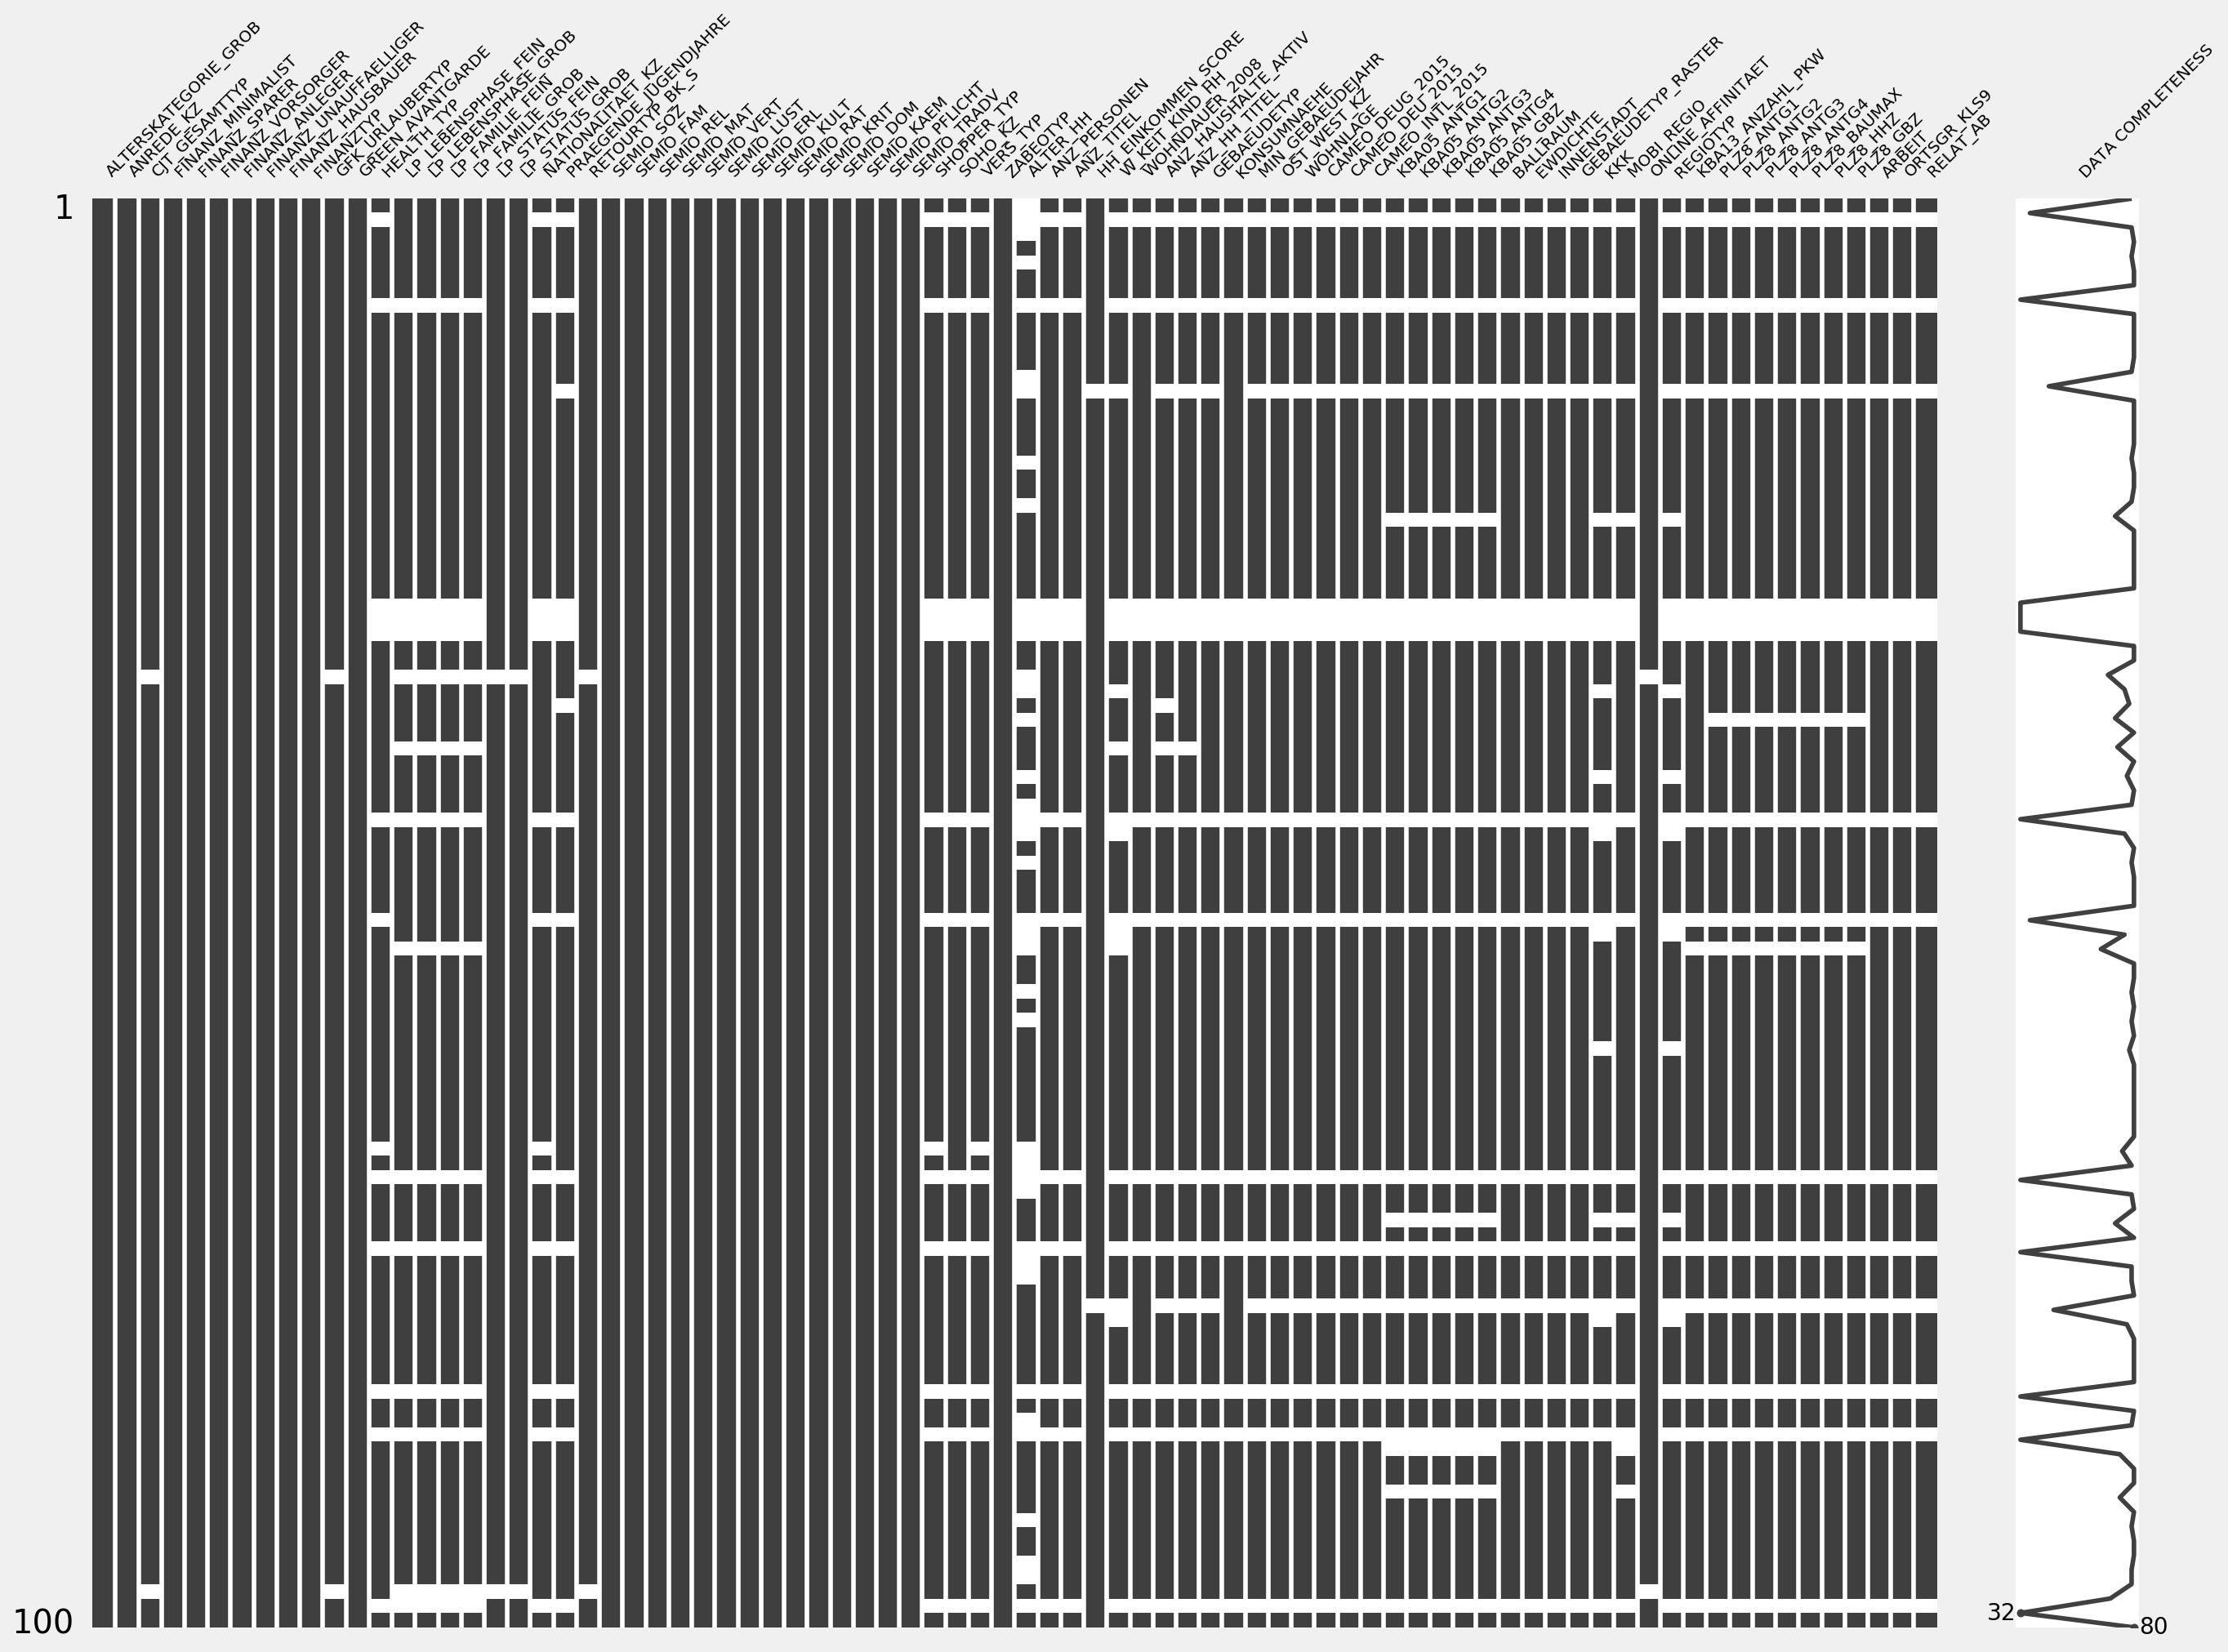

In [19]:
# How much data is missing in each row of the dataset?
msno.matrix(df_clean.sample(100), figsize=(20, 15), labels=True, fontsize=10)
plt.show()

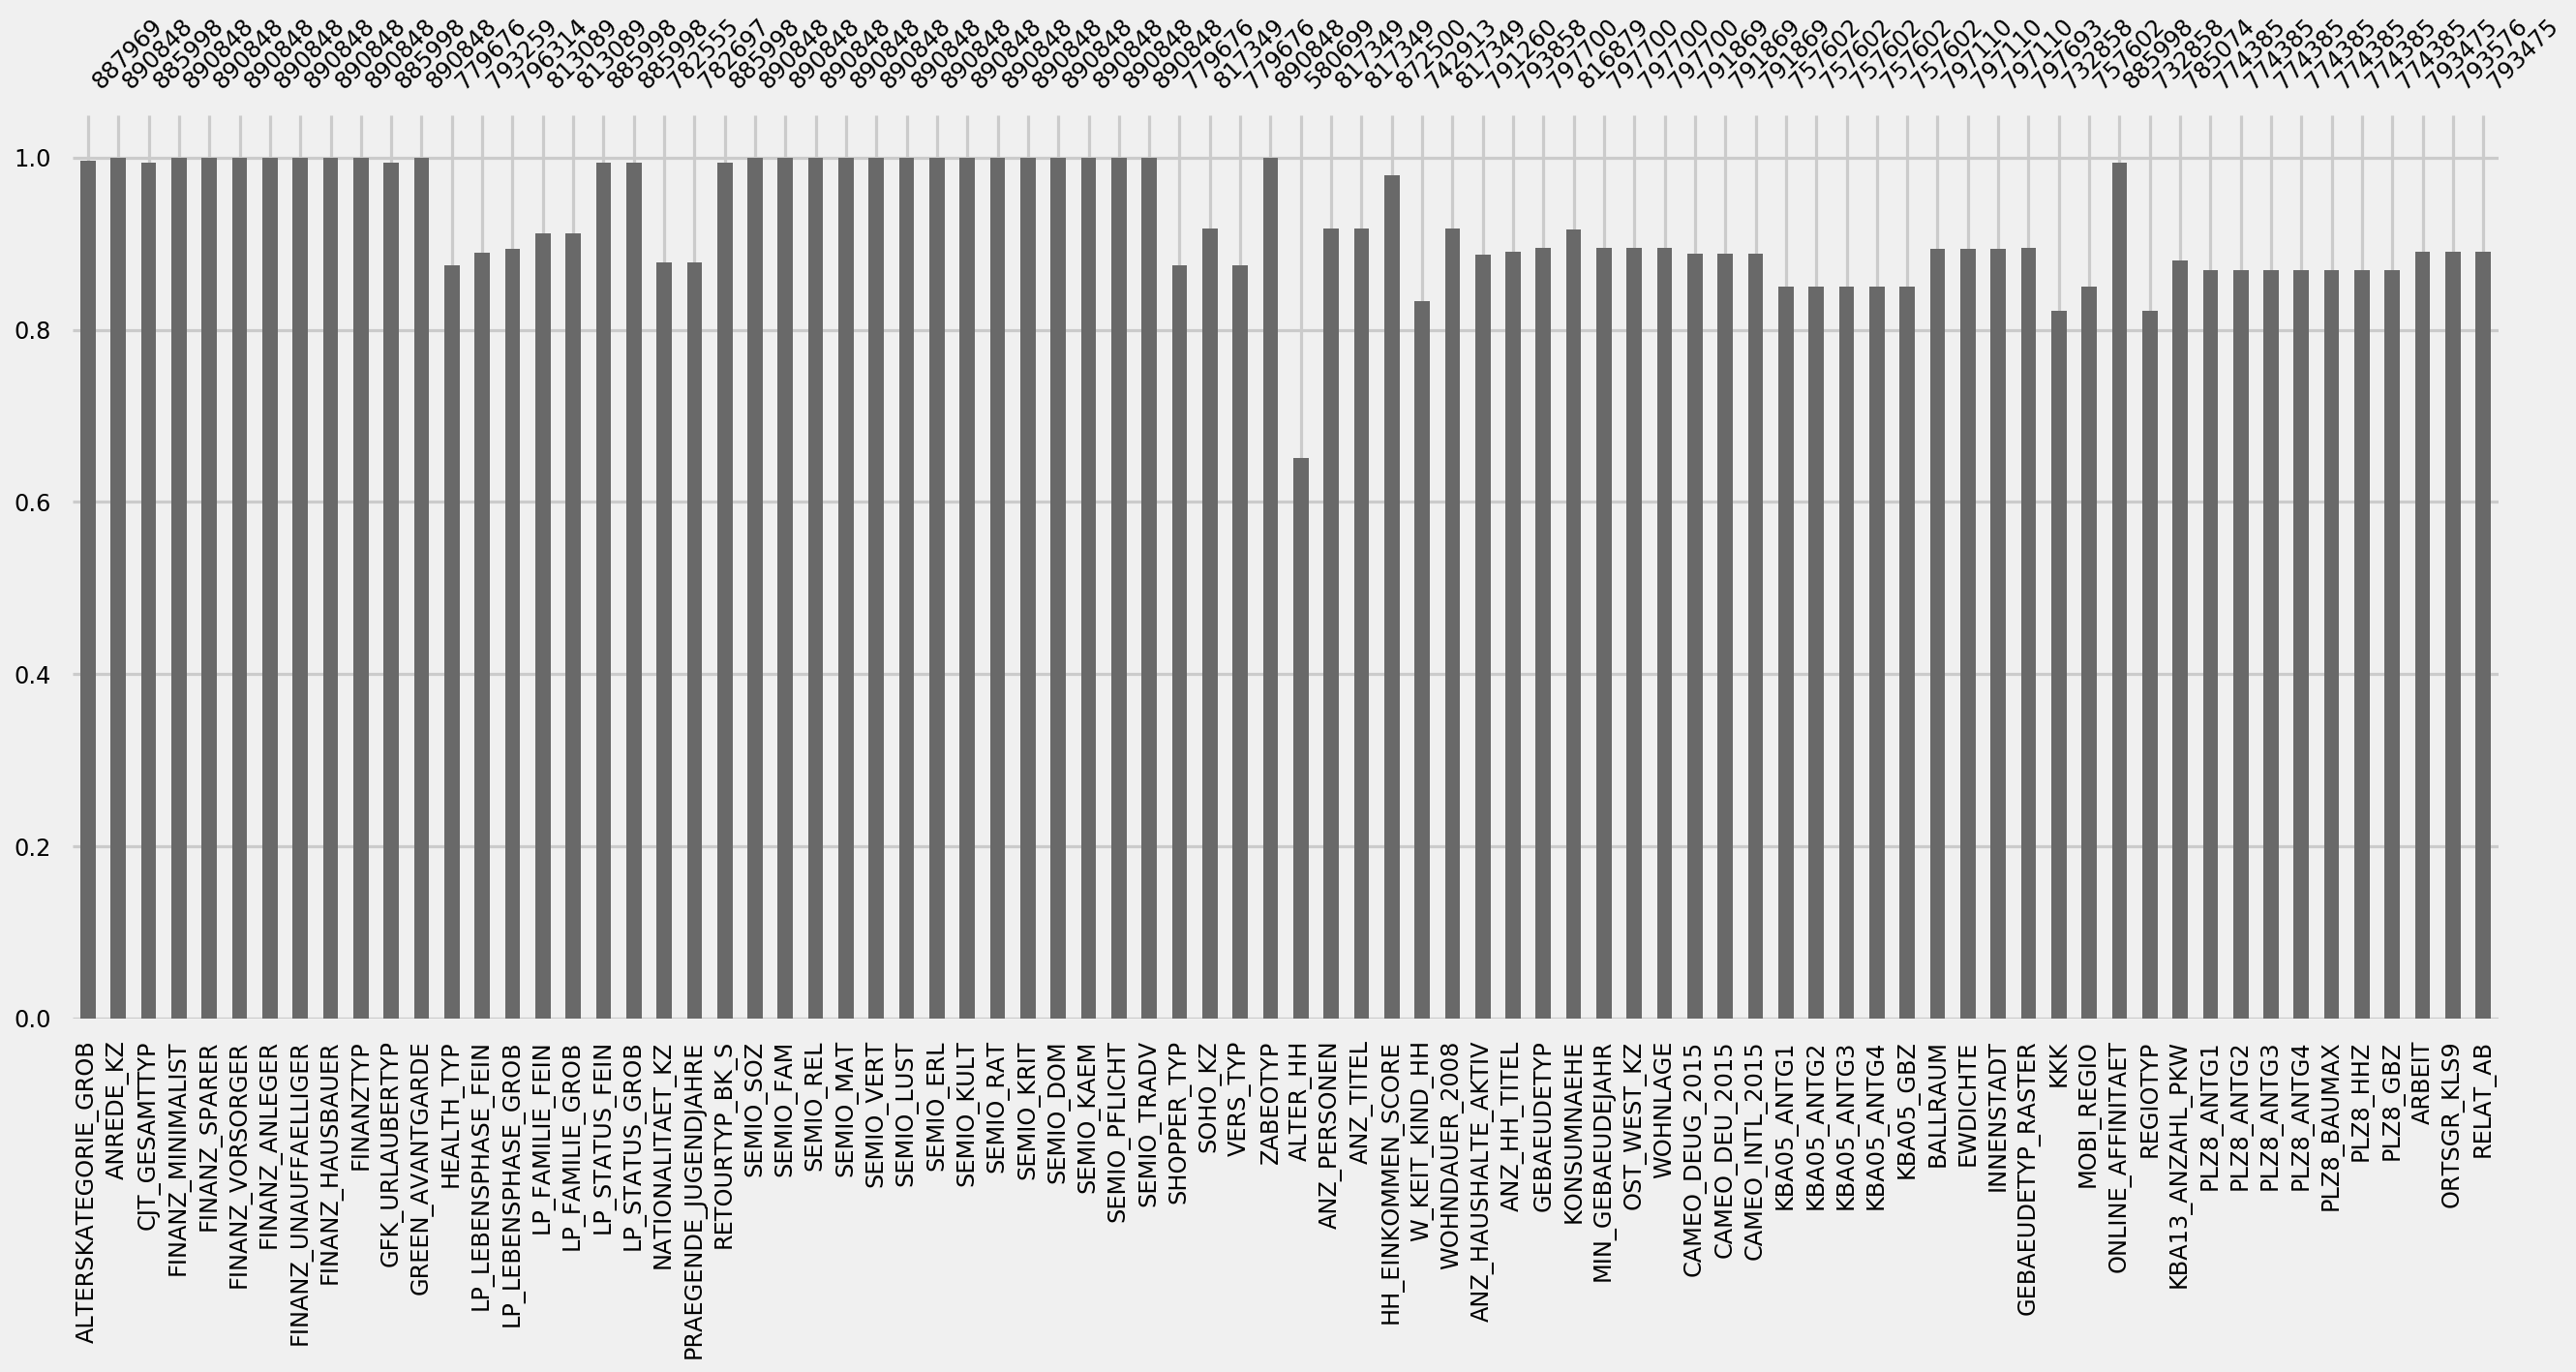

In [20]:
msno.bar(df_clean, figsize=(20, 8), fontsize=12)
plt.show()

From my visual evaluation I can see that the rows with missing data tend to have a pattern where they're missing all of the household and building-level features. Most of these rows seem to be missing `HEALTH_TYP`. The easiest way to do this is to test if `HEALTH_TYP` is null, that column will be missing in all of the cases we're testing for.

In [21]:
# Create a new dataframe that contains only the "complete" rows
df_subset = df_clean.query('HEALTH_TYP != "NaN"')

# Create another dataframe that contains only the "incomplete" rows
df_incomplete = df_clean.query('HEALTH_TYP == "NaN"')

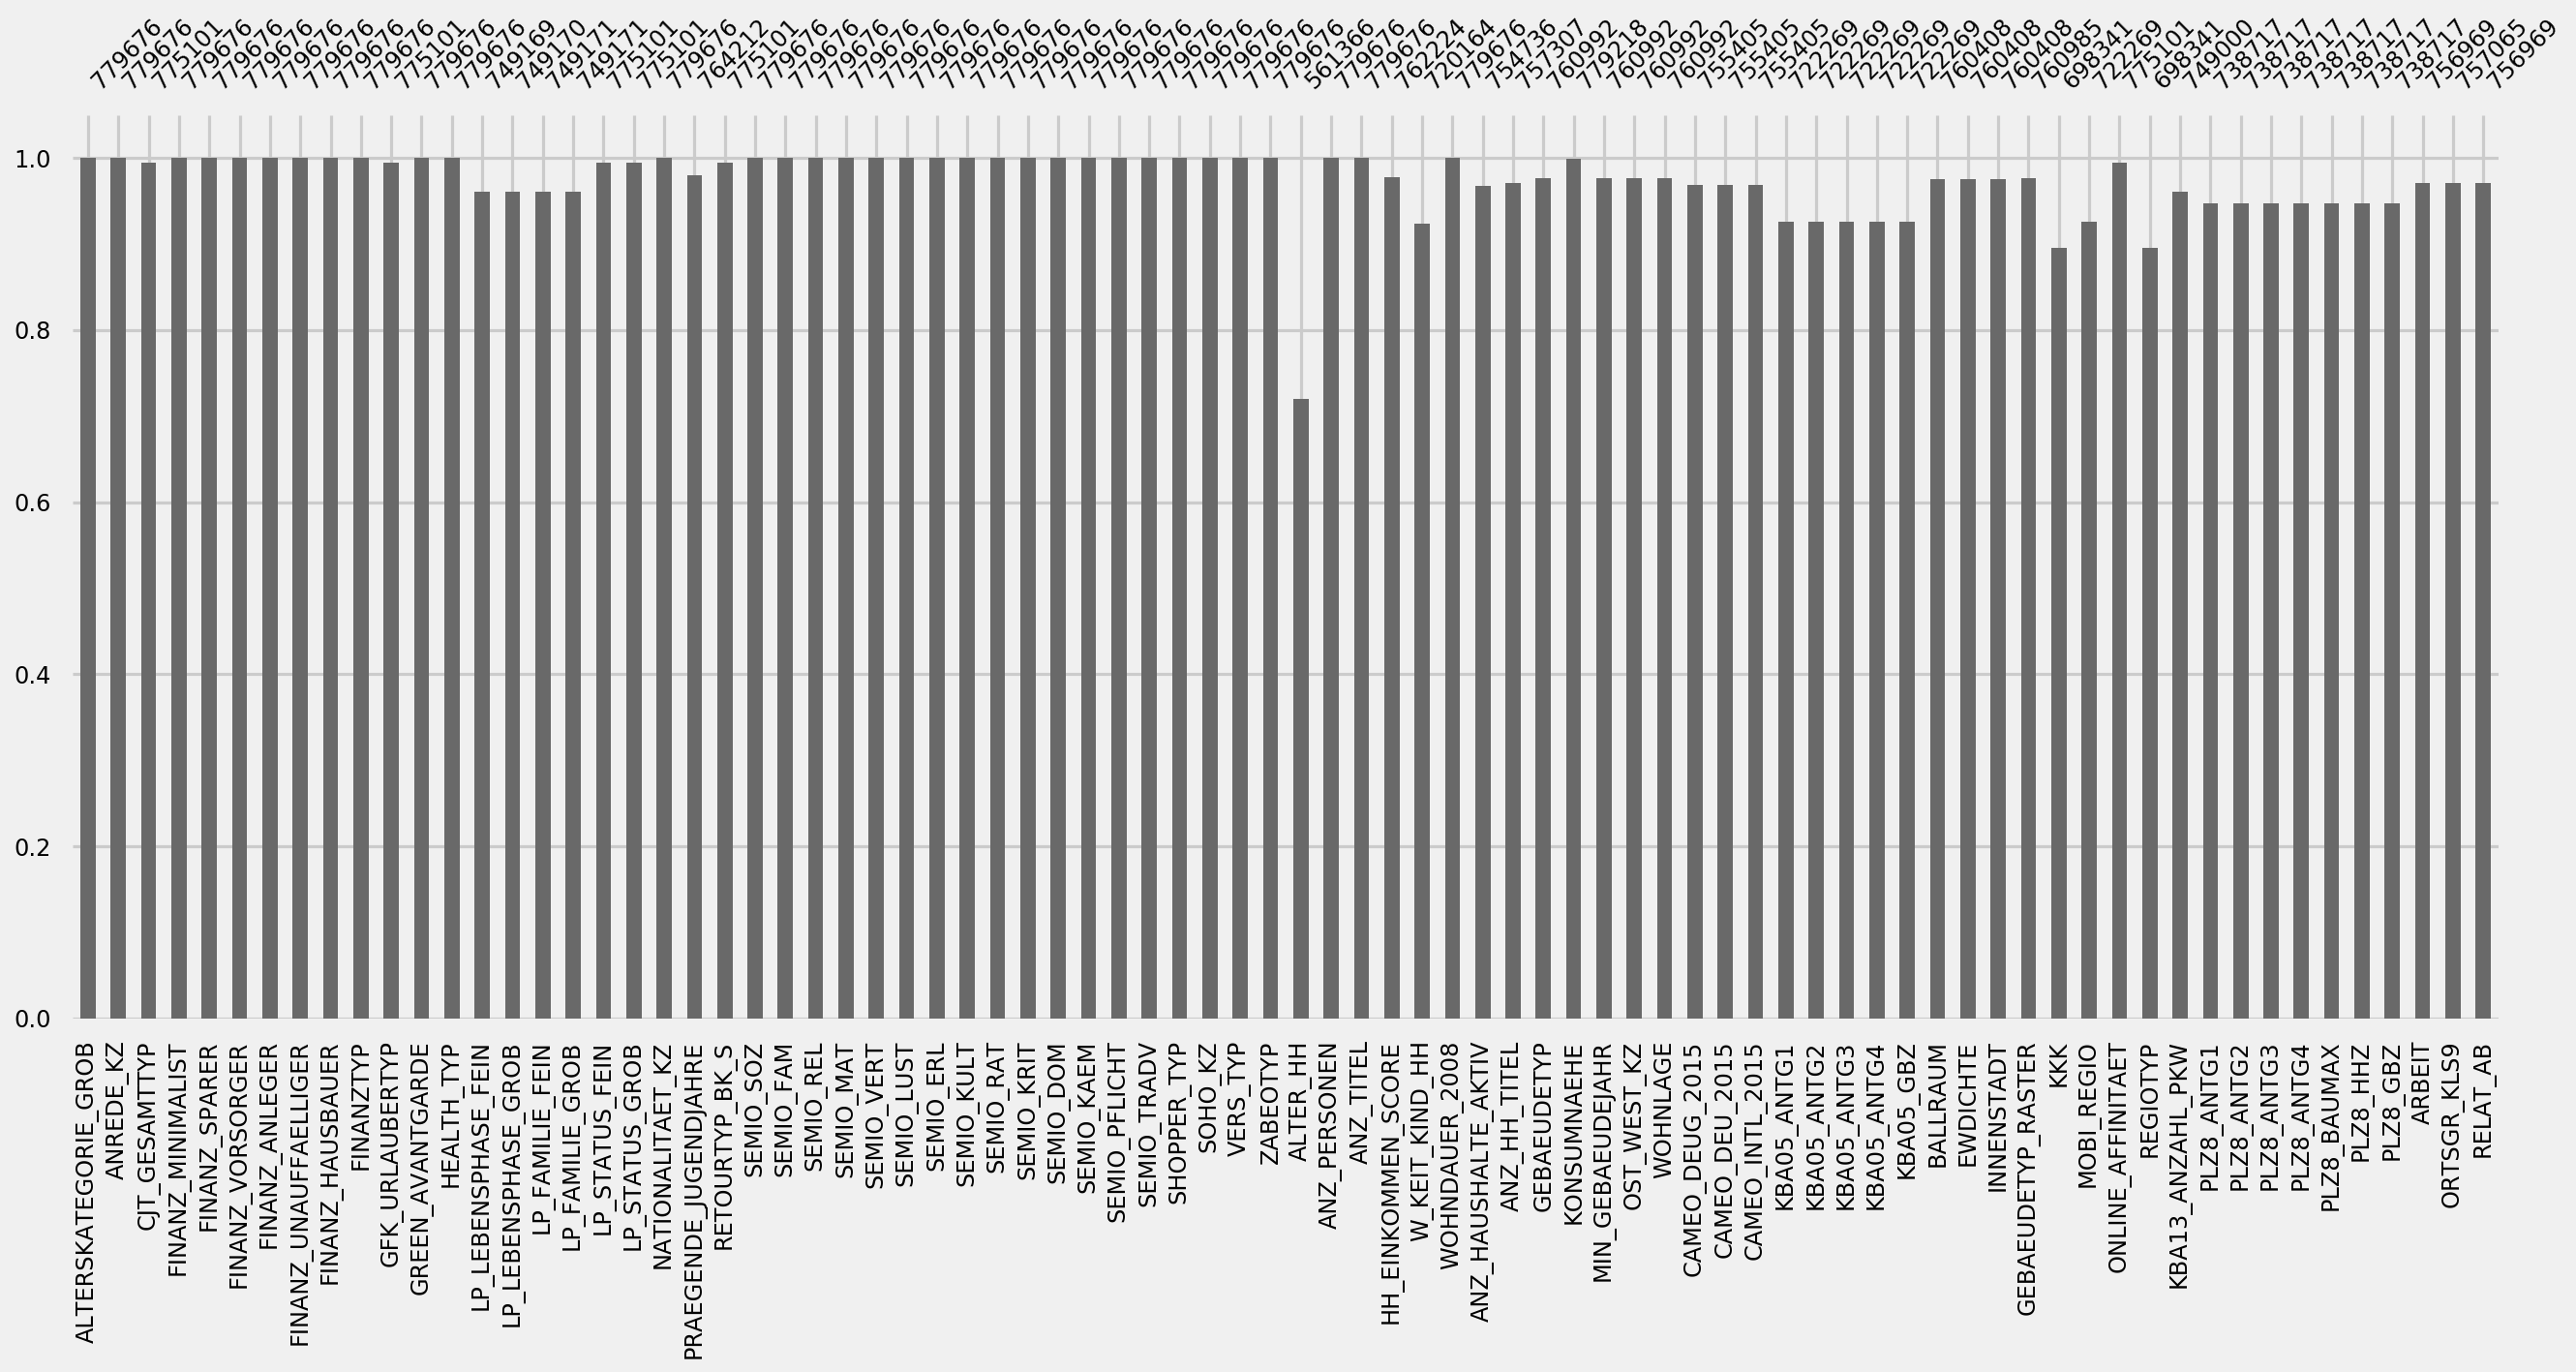

In [22]:
# Test our missing distribution again to make sure the rows look mostly complete
msno.bar(df_subset, figsize=(20, 8), fontsize=12)
plt.show()

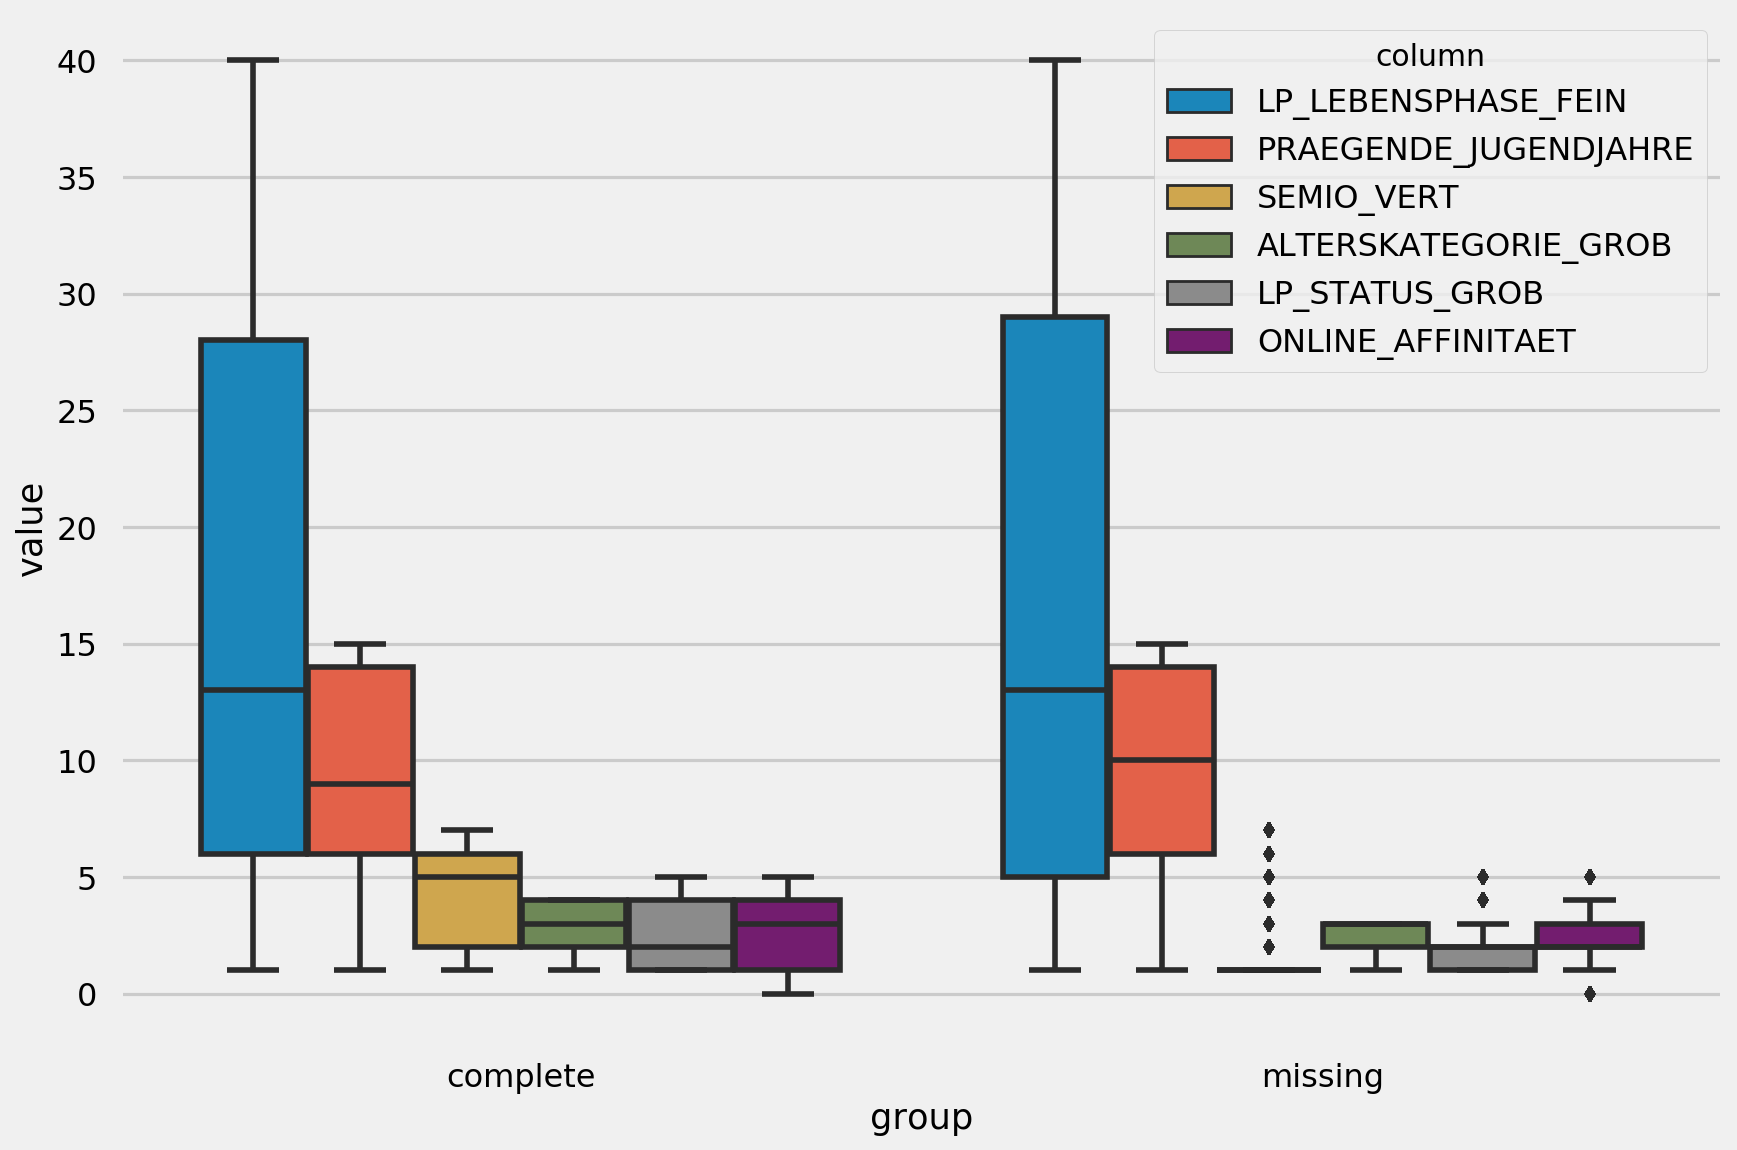

In [23]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
df1 = pd.DataFrame(df_subset,
                   columns=[
                       'LP_LEBENSPHASE_FEIN', 'PRAEGENDE_JUGENDJAHRE',
                       'SEMIO_VERT', 'ALTERSKATEGORIE_GROB', 'LP_STATUS_GROB',
                       'ONLINE_AFFINITAET'
                   ]).assign(group='complete')
df2 = pd.DataFrame(df_incomplete,
                   columns=[
                       'LP_LEBENSPHASE_FEIN', 'PRAEGENDE_JUGENDJAHRE',
                       'SEMIO_VERT', 'ALTERSKATEGORIE_GROB', 'LP_STATUS_GROB',
                       'ONLINE_AFFINITAET'
                   ]).assign(group='missing')

cdf = pd.concat([df1, df2])
mdf = pd.melt(cdf, id_vars=['group'], var_name=['column'])
ax = sns.boxplot(x="group", y="value", hue="column", data=mdf)
plt.show()


There doesn't appear to be a significant difference between the two subsets on the columns I investigated. For that reason I'm going to proceed with dropping all rows with missing data.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [24]:
# How many features are there of each data type?
feat_info.groupby('type')['attribute'].value_counts()


type         attribute            
categorical  AGER_TYP                 1
             ANREDE_KZ                1
             CAMEO_DEUG_2015          1
             CAMEO_DEU_2015           1
             CJT_GESAMTTYP            1
             FINANZTYP                1
             GEBAEUDETYP              1
             GFK_URLAUBERTYP          1
             GREEN_AVANTGARDE         1
             KK_KUNDENTYP             1
             LP_FAMILIE_FEIN          1
             LP_FAMILIE_GROB          1
             LP_STATUS_FEIN           1
             LP_STATUS_GROB           1
             NATIONALITAET_KZ         1
             OST_WEST_KZ              1
             SHOPPER_TYP              1
             SOHO_KZ                  1
             TITEL_KZ                 1
             VERS_TYP                 1
             ZABEOTYP                 1
interval     ALTER_HH                 1
mixed        CAMEO_INTL_2015          1
             KBA05_BAUMAX             1
     

In [25]:
feat_info.query('type == "categorical"')['attribute'].to_list()

['AGER_TYP',
 'ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'TITEL_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'KK_KUNDENTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [26]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?


In [28]:
# Re-encode categorical variable(s) to be kept in the analysis.

# One-hot encode the multi-level categoricals and string columns
df_subset = pd.get_dummies(
    df_subset,
    columns=[
        'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP',
        'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN',
        'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
        'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP',
        'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ',
        'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'
    ],
    prefix_sep='_')


In [29]:
df_subset.head()

ALTERSKATEGORIE_GROB  FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  \
1                   1.0                1.0            5.0               2.0   
2                   3.0                1.0            4.0               1.0   
3                   4.0                4.0            2.0               5.0   
4                   3.0                4.0            3.0               4.0   
5                   1.0                3.0            1.0               5.0   

   FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  HEALTH_TYP  \
1             5.0                    4.0               5.0         3.0   
2             2.0                    3.0               5.0         3.0   
3             2.0                    1.0               2.0         2.0   
4             1.0                    3.0               2.0         3.0   
5             2.0                    2.0               5.0         3.0   

   LP_LEBENSPHASE_FEIN  LP_LEBENSPHASE_GROB  PRAEGENDE_JUGENDJAHRE  \
1                 21.0                  6.0                   14.0   
2                  3.0                  1.0                   15.0   
3                  NaN                  NaN                    8.0   
4                 32.0                 10.0                    8.0   
5                  8.0                  2.0                    3.0   

   RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  \
1             1.0        5.0        4.0        4.0        3.0         1.0   
2             3.0        4.0        1.0        3.0        3.0         4.0   
3             2.0        5.0        1.0        2.0        1.0         4.0   
4             5.0        6.0        4.0        4.0        2.0         7.0   
5             3.0        2.0        4.0        7.0        4.0         2.0   

   SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  \
1         2.0        2.0         3.0        6.0         4.0        7.0   
2         4.0        6.0         3.0        4.0         7.0        7.0   
3         4.0        7.0         4.0        3.0         4.0        4.0   
4         4.0        4.0         6.0        2.0         3.0        2.0   
5         2.0        2.0         5.0        7.0         4.0        4.0   

   SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  ALTER_HH  ANZ_PERSONEN  ANZ_TITEL  \
1         4.0            7.0          6.0       NaN           2.0        0.0   
2         7.0            3.0          3.0      17.0           1.0        0.0   
3         5.0            4.0          4.0      13.0           0.0        0.0   
4         2.0            4.0          2.0      20.0           4.0        0.0   
5         4.0            7.0          6.0      10.0           1.0        0.0   

   HH_EINKOMMEN_SCORE  W_KEIT_KIND_HH  WOHNDAUER_2008  ANZ_HAUSHALTE_AKTIV  \
1                 6.0             3.0             9.0                 11.0   
2                 4.0             3.0             9.0                 10.0   
3                 1.0             NaN             9.0                  1.0   
4                 5.0             2.0             9.0                  3.0   
5                 5.0             6.0             9.0                  5.0   

   ANZ_HH_TITEL  KONSUMNAEHE  MIN_GEBAEUDEJAHR  WOHNLAGE  CAMEO_INTL_2015  \
1           0.0          1.0            1992.0       4.0             51.0   
2           0.0          5.0            1992.0       2.0             24.0   
3           0.0          4.0            1997.0       7.0             12.0   
4           0.0          4.0            1992.0       3.0             43.0   
5           0.0          5.0            1992.0       7.0             54.0   

   KBA05_ANTG1  KBA05_ANTG2  KBA05_ANTG3  KBA05_ANTG4  KBA05_GBZ  BALLRAUM  \
1          0.0          0.0          0.0          2.0        1.0       6.0   
2          1.0          3.0          1.0          0.0        3.0       2.0   
3          4.0          1.0          0.0          0.0        4.0       4.0   
4          1.0          4.0  

In [30]:
df_subset.shape

(779676, 200)

#### Discussion 1.2.1: Re-Encode Categorical Features

I took all of the categorical columns and one-hot encoded them. I considered transforming the one binary variable `OST_WEST_KZ` but realized it would transform quite nicely into two one-hot encoded variables. I decided not to drop any columns at this stage.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

```
1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)

-1: unknown
0: unknown
1: 40s - war years (Mainstream, E+W)
2: 40s - reconstruction years (Avantgarde, E+W)
3: 50s - economic miracle (Mainstream, E+W)
4: 50s - milk bar / Individualisation (Avantgarde, E+W)
5: 60s - economic miracle (Mainstream, E+W)
6: 60s - generation 68 / student protestors (Avantgarde, W)
7: 60s - opponents to the building of the Wall (Avantgarde, E)
8: 70s - family orientation (Mainstream, E+W)
9: 70s - peace movement (Avantgarde, E+W)
10: 80s - Generation Golf (Mainstream, W)
11: 80s - ecological awareness (Avantgarde, W)
12: 80s - FDJ / communist party youth organisation (Mainstream, E)
13: 80s - Swords into ploughshares (Avantgarde, E)
14: 90s - digital media kids (Mainstream, E+W)
15: 90s - ecological awareness (Avantgarde, E+W)
```

In [31]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables

# Create new one-hot encoded columns
df_subset['DECADE_40s'] = df_subset['PRAEGENDE_JUGENDJAHRE'].apply(
    lambda x: 1 if x >= 1 and x <= 2 else 0)
df_subset['DECADE_50s'] = df_subset['PRAEGENDE_JUGENDJAHRE'].apply(
    lambda x: 1 if x >= 3 and x <= 4 else 0)
df_subset['DECADE_60s'] = df_subset['PRAEGENDE_JUGENDJAHRE'].apply(
    lambda x: 1 if x >= 5 and x <= 7 else 0)
df_subset['DECADE_70s'] = df_subset['PRAEGENDE_JUGENDJAHRE'].apply(
    lambda x: 1 if x >= 8 and x <= 9 else 0)
df_subset['DECADE_80s'] = df_subset['PRAEGENDE_JUGENDJAHRE'].apply(
    lambda x: 1 if x >= 10 and x <= 13 else 0)
df_subset['DECADE_90s'] = df_subset['PRAEGENDE_JUGENDJAHRE'].apply(
    lambda x: 1 if x >= 14 and x <= 15 else 0)


In [32]:
# Create new one-hot encoded movement columns

df_subset['MOVEMENT_MAINSTREAM'] = df_subset['PRAEGENDE_JUGENDJAHRE'].apply(
    lambda x: 1 if x in [1, 3, 5, 8, 10, 12, 14] else 0)
df_subset['MOVEMENT_AVANTGARDE'] = df_subset['PRAEGENDE_JUGENDJAHRE'].apply(
    lambda x: 1 if x in [2, 4, 6, 7, 9, 11, 13, 15] else 0)

In [33]:
# Drop the original column
df_subset = df_subset.drop(columns=['PRAEGENDE_JUGENDJAHRE'])

In [34]:
# Test a sample of rows
df_subset.sample(10)

ALTERSKATEGORIE_GROB  FINANZ_MINIMALIST  FINANZ_SPARER  \
407127                   3.0                3.0            2.0   
821429                   4.0                5.0            1.0   
92298                    4.0                4.0            1.0   
555127                   1.0                2.0            1.0   
81741                    2.0                1.0            4.0   
360921                   2.0                3.0            2.0   
784586                   1.0                1.0            5.0   
575821                   3.0                2.0            3.0   
724091                   1.0                1.0            5.0   
612183                   4.0                5.0            2.0   

        FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
407127               3.0             4.0                    2.0   
821429               5.0             2.0                    1.0   
92298                4.0             3.0                    1.0   
555127               5.0             1.0                    1.0   
81741                1.0             5.0                    3.0   
360921               3.0             4.0                    1.0   
784586               3.0             5.0                    4.0   
575821               3.0             4.0                    2.0   
724091               3.0             5.0                    5.0   
612183               4.0             4.0                    1.0   

        FINANZ_HAUSBAUER  HEALTH_TYP  LP_LEBENSPHASE_FEIN  \
407127               4.0         2.0                 32.0   
821429               4.0         2.0                 12.0   
92298                3.0         2.0                  8.0   
555127               5.0         3.0                  6.0   
81741                4.0         2.0                  2.0   
360921               1.0         1.0                 10.0   
784586               5.0         3.0                 29.0   
575821               4.0         3.0                  7.0   
724091               5.0         1.0                 21.0   
612183               1.0         2.0                 37.0   

        LP_LEBENSPHASE_GROB  RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  \
407127                 10.0             3.0        5.0        1.0        1.0   
821429                  3.0             5.0        6.0        5.0        3.0   
92298                   2.0             3.0        5.0        1.0        1.0   
555127                  2.0             5.0        5.0        2.0        5.0   
81741                   1.0             3.0        3.0        5.0        5.0   
360921                  3.0             5.0        2.0        2.0        7.0   
784586                  9.0             2.0        3.0        4.0        4.0   
575821                  2.0             5.0        2.0        3.0        3.0   
724091                  6.0             2.0        2.0        2.0        7.0   
612183                 12.0             5.0        4.0        1.0        4.0   

        SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  \
407127        2.0         2.0         6.0        6.0         3.0        4.0   
821429        4.0         7.0         5.0        3.0         4.0        3.0   
92298         1.0         2.0         7.0        7.0         2.0        3.0   
555127        3.0         1.0         3.0        4.0         2.0        6.0   
81741         7.0         4.0         4.0        5.0         4.0        4.0   
360921        7.0         2.0         6.0        5.0         6.0        7.0   
784586        4.0         1.0         2.0        2.0         2.0        6.0   
575821        5.0         4.0         6.0        6.0         3.0        4.0   
724091        4.0         2.0         1.0        2.0         5.0        7.0   
612183        3.0         3.0         7.0        7.0         2.0        2.0   

        SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  \
407127         4.0        7.0         7.0      

```
4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code

-1: unknown
11: Wealthy Households - Pre-Family Couples & Singles
12: Wealthy Households - Young Couples With Children
13: Wealthy Households - Families With School Age Children
14: Wealthy Households - Older Families & Mature Couples
15: Wealthy Households - Elders In Retirement
21: Prosperous Households - Pre-Family Couples & Singles
22: Prosperous Households - Young Couples With Children
23: Prosperous Households - Families With School Age Children
24: Prosperous Households - Older Families & Mature Couples
25: Prosperous Households - Elders In Retirement
31: Comfortable Households - Pre-Family Couples & Singles
32: Comfortable Households - Young Couples With Children
33: Comfortable Households - Families With School Age Children
34: Comfortable Households - Older Families & Mature Couples
35: Comfortable Households - Elders In Retirement
41: Less Affluent Households - Pre-Family Couples & Singles
42: Less Affluent Households - Young Couples With Children
43: Less Affluent Households - Families With School Age Children
44: Less Affluent Households - Older Families & Mature Couples
45: Less Affluent Households - Elders In Retirement
51: Poorer Households - Pre-Family Couples & Singles
52: Poorer Households - Young Couples With Children
53: Poorer Households - Families With School Age Children
54: Poorer Households - Older Families & Mature Couples
55: Poorer Households - Elders In Retirement
XX: unknown
```

In [35]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# Split into two columns with 10s and 1s values
df_subset['CAMEO_WEALTH'], df_subset['CAMEO_LIFESTAGE'] = divmod(
    pd.to_numeric(df_subset['CAMEO_INTL_2015'], downcast='integer'), 10)

# Drop the original column
df_subset = df_subset.drop(columns=['CAMEO_INTL_2015'])

# And then one-hot encode the new columns
# One-hot encode the multi-level categoricals and string columns
df_subset = pd.get_dummies(
    df_subset,
    columns=[
        'CAMEO_WEALTH', 'CAMEO_LIFESTAGE'
    ],
    prefix_sep='_')

#### Discussion 1.2.2: Engineer Mixed-Type Features

I converted `PRAEGENDE_JUGENDJAHRE` into two new one-hot encoded features that capture decade and movement. I then split `CAMEO_INTL_2015` into two new one-hot encoded features using the first digit (wealth) and the second digit (lifestage).

In [36]:
df_subset.dtypes

ALTERSKATEGORIE_GROB     float64
FINANZ_MINIMALIST        float64
FINANZ_SPARER            float64
FINANZ_VORSORGER         float64
FINANZ_ANLEGER           float64
FINANZ_UNAUFFAELLIGER    float64
FINANZ_HAUSBAUER         float64
HEALTH_TYP               float64
LP_LEBENSPHASE_FEIN      float64
LP_LEBENSPHASE_GROB      float64
RETOURTYP_BK_S           float64
SEMIO_SOZ                float64
SEMIO_FAM                float64
SEMIO_REL                float64
SEMIO_MAT                float64
SEMIO_VERT               float64
SEMIO_LUST               float64
SEMIO_ERL                float64
SEMIO_KULT               float64
SEMIO_RAT                float64
SEMIO_KRIT               float64
SEMIO_DOM                float64
SEMIO_KAEM               float64
SEMIO_PFLICHT            float64
SEMIO_TRADV              float64
ALTER_HH                 float64
ANZ_PERSONEN             float64
ANZ_TITEL                float64
HH_EINKOMMEN_SCORE       float64
W_KEIT_KIND_HH           float64
WOHNDAUER_

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [37]:
def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data

    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """

    # Identify missing or unknown data values and convert them to NaNs.
    df.loc[df['CAMEO_DEUG_2015'] == 'X'] = np.nan
    df.loc[df['CAMEO_DEU_2015'] == 'XX'] = np.nan
    df.loc[df['CAMEO_INTL_2015'] == 'XX'] = np.nan

    # Now convert two of the columns to numeric since strings are gone, keep _DEU_ as string
    df['CAMEO_DEUG_2015'] = pd.to_numeric(df['CAMEO_DEUG_2015'],
                                          errors='coerce')
    df['CAMEO_INTL_2015'] = pd.to_numeric(df['CAMEO_INTL_2015'],
                                          errors='coerce')

    # Iterate over the feat_info df - this is not the most efficient
    # way to do it, and I'd like to try to handle the string values
    # in one single for-loop as an improvement
    for index, row in feat_info.iterrows():
        attr = row['attribute']
        # Strip out the brackets and separate on comma
        values = row['missing_or_unknown'].replace('[',
                                                   '').replace(']',
                                                               '').split(',')
        for val in values:
            # We still have strings in here (X / XX) so ignore them
            if val not in ['', 'X', 'XX']:
                val = int(val)
                df.loc[df[attr] == val, attr] = np.nan

    # Create new one-hot encoded decade columns
    df['DECADE_40s'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 1 if x >= 1
                                                         and x <= 2 else 0)
    df['DECADE_50s'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 1 if x >= 3
                                                         and x <= 4 else 0)
    df['DECADE_60s'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 1 if x >= 5
                                                         and x <= 7 else 0)
    df['DECADE_70s'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 1 if x >= 8
                                                         and x <= 9 else 0)
    df['DECADE_80s'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 1 if x >= 10
                                                         and x <= 13 else 0)
    df['DECADE_90s'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 1 if x >= 14
                                                         and x <= 15 else 0)

    # Create new one-hot encoded movement columns
    df['MOVEMENT_MAINSTREAM'] = df['PRAEGENDE_JUGENDJAHRE'].apply(
        lambda x: 1 if x in [1, 3, 5, 8, 10, 12, 14] else 0)
    df['MOVEMENT_AVANTGARDE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(
        lambda x: 1 if x in [2, 4, 6, 7, 9, 11, 13, 15] else 0)

    # Drop the rows with missing values
    df = df.query('HEALTH_TYP != "NaN"')

    # Split CAMEO_WEALTH into two columns with 10s and 1s values
    df['CAMEO_WEALTH'], df['CAMEO_LIFESTAGE'] = divmod(
        pd.to_numeric(df['CAMEO_INTL_2015'], downcast='integer'), 10)

    df = pd.get_dummies(
        df,
        columns=[
            'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP',
            'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
            'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ',
            'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP',
            'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_WEALTH',
            'CAMEO_LIFESTAGE'
        ],
        prefix_sep='_')

    # Drop unneeded columns
    df = df.drop(columns=[
        'TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR',
        'CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE'
    ])

    return df


In [38]:
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
azdias = clean_data(azdias, feat_info)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [39]:
# Because I optimized the function, our columns will be in different orders
# reorder them alphabetically so we can compare them properly
df_subset = df_subset.reindex(sorted(df_subset.columns), axis=1)
azdias = azdias.reindex(sorted(azdias.columns), axis=1)

In [40]:
# Quick test to ensure our dataframes match, compare the first 100 rows
# of each. We expect no output if they match perfectly.
pd.concat([df_subset.head(100),
           azdias.head(100)]).drop_duplicates(keep=False)


Empty DataFrame
Columns: [ALTERSKATEGORIE_GROB, ALTER_HH, ANREDE_KZ_1.0, ANREDE_KZ_2.0, ANZ_HAUSHALTE_AKTIV, ANZ_HH_TITEL, ANZ_PERSONEN, ANZ_TITEL, ARBEIT, BALLRAUM, CAMEO_DEUG_2015_1.0, CAMEO_DEUG_2015_2.0, CAMEO_DEUG_2015_3.0, CAMEO_DEUG_2015_4.0, CAMEO_DEUG_2015_5.0, CAMEO_DEUG_2015_6.0, CAMEO_DEUG_2015_7.0, CAMEO_DEUG_2015_8.0, CAMEO_DEUG_2015_9.0, CAMEO_DEU_2015_1A, CAMEO_DEU_2015_1B, CAMEO_DEU_2015_1C, CAMEO_DEU_2015_1D, CAMEO_DEU_2015_1E, CAMEO_DEU_2015_2A, CAMEO_DEU_2015_2B, CAMEO_DEU_2015_2C, CAMEO_DEU_2015_2D, CAMEO_DEU_2015_3A, CAMEO_DEU_2015_3B, CAMEO_DEU_2015_3C, CAMEO_DEU_2015_3D, CAMEO_DEU_2015_4A, CAMEO_DEU_2015_4B, CAMEO_DEU_2015_4C, CAMEO_DEU_2015_4D, CAMEO_DEU_2015_4E, CAMEO_DEU_2015_5A, CAMEO_DEU_2015_5B, CAMEO_DEU_2015_5C, CAMEO_DEU_2015_5D, CAMEO_DEU_2015_5E, CAMEO_DEU_2015_5F, CAMEO_DEU_2015_6A, CAMEO_DEU_2015_6B, CAMEO_DEU_2015_6C, CAMEO_DEU_2015_6D, CAMEO_DEU_2015_6E, CAMEO_DEU_2015_6F, CAMEO_DEU_2015_7A, CAMEO_DEU_2015_7B, CAMEO_DEU_2015_7C, CAMEO_DEU_2015_7D, CAMEO_DEU_2015_7E, CAMEO_DEU_2015_8A, CAMEO_DEU_2015_8B, CAMEO_DEU_2015_8C, CAMEO_DEU_2015_8D, CAMEO_DEU_2015_9A, CAMEO_DEU_2015_9B, CAMEO_DEU_2015_9C, CAMEO_DEU_2015_9D, CAMEO_DEU_2015_9E, CAMEO_LIFESTAGE_1.0, CAMEO_LIFESTAGE_2.0, CAMEO_LIFESTAGE_3.0, CAMEO_LIFESTAGE_4.0, CAMEO_LIFESTAGE_5.0, CAMEO_WEALTH_1.0, CAMEO_WEALTH_2.0, CAMEO_WEALTH_3.0, CAMEO_WEALTH_4.0, CAMEO_WEALTH_5.0, CJT_GESAMTTYP_1.0, CJT_GESAMTTYP_2.0, CJT_GESAMTTYP_3.0, CJT_GESAMTTYP_4.0, CJT_GESAMTTYP_5.0, CJT_GESAMTTYP_6.0, DECADE_40s, DECADE_50s, DECADE_60s, DECADE_70s, DECADE_80s, DECADE_90s, EWDICHTE, FINANZTYP_1.0, FINANZTYP_2.0, FINANZTYP_3.0, FINANZTYP_4.0, FINANZTYP_5.0, FINANZTYP_6.0, FINANZ_ANLEGER, FINANZ_HAUSBAUER, FINANZ_MINIMALIST, FINANZ_SPARER, FINANZ_UNAUFFAELLIGER, FINANZ_VORSORGER, GEBAEUDETYP_1.0, GEBAEUDETYP_2.0, ...]
Index: []

[0 rows x 216 columns]

In [41]:
azdias.shape

(779676, 216)

In [42]:
df_subset.shape

(779676, 216)

Great! So now we know our function will apply the same the exact same transformations as we did above. We'll use `azdias` as our cleaned version of the demographics dataframe going into section 2.

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [43]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias.isnull().sum().sort_values(ascending=False).head(40)

ALTER_HH               218310
KKK                     81335
REGIOTYP                81335
W_KEIT_KIND_HH          59512
KBA05_ANTG2             57407
KBA05_ANTG3             57407
KBA05_ANTG4             57407
KBA05_GBZ               57407
MOBI_REGIO              57407
KBA05_ANTG1             57407
PLZ8_BAUMAX             40959
PLZ8_ANTG2              40959
PLZ8_HHZ                40959
PLZ8_GBZ                40959
PLZ8_ANTG4              40959
PLZ8_ANTG3              40959
PLZ8_ANTG1              40959
KBA13_ANZAHL_PKW        30676
LP_LEBENSPHASE_FEIN     30507
LP_LEBENSPHASE_GROB     30506
ANZ_HAUSHALTE_AKTIV     24940
RELAT_AB                22707
ARBEIT                  22707
ORTSGR_KLS9             22611
ANZ_HH_TITEL            22369
EWDICHTE                19268
BALLRAUM                19268
INNENSTADT              19268
GEBAEUDETYP_RASTER      18691
WOHNLAGE                18684
MIN_GEBAEUDEJAHR        18684
HH_EINKOMMEN_SCORE      17452
RETOURTYP_BK_S           4575
ONLINE_AFF

I've confirmed that none of the columns with NaNs are categorical. So we will replace NaNs with median values.

In [44]:
impute = SimpleImputer(missing_values=np.nan, strategy='median')

azdias[[
    'ALTER_HH', 'KKK', 'REGIOTYP', 'W_KEIT_KIND_HH', 'KBA05_ANTG2',
    'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'MOBI_REGIO', 'KBA05_ANTG1',
    'PLZ8_BAUMAX', 'PLZ8_ANTG2', 'PLZ8_HHZ', 'PLZ8_GBZ', 'PLZ8_ANTG4',
    'PLZ8_ANTG3', 'PLZ8_ANTG1', 'KBA13_ANZAHL_PKW', 'LP_LEBENSPHASE_FEIN',
    'LP_LEBENSPHASE_GROB', 'ANZ_HAUSHALTE_AKTIV', 'RELAT_AB', 'ARBEIT',
    'ORTSGR_KLS9', 'ANZ_HH_TITEL', 'EWDICHTE', 'BALLRAUM', 'INNENSTADT',
    'GEBAEUDETYP_RASTER', 'WOHNLAGE', 'MIN_GEBAEUDEJAHR', 'HH_EINKOMMEN_SCORE',
    'RETOURTYP_BK_S', 'ONLINE_AFFINITAET', 'KONSUMNAEHE'
]] = impute.fit_transform(azdias[[
    'ALTER_HH', 'KKK', 'REGIOTYP', 'W_KEIT_KIND_HH', 'KBA05_ANTG2',
    'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'MOBI_REGIO', 'KBA05_ANTG1',
    'PLZ8_BAUMAX', 'PLZ8_ANTG2', 'PLZ8_HHZ', 'PLZ8_GBZ', 'PLZ8_ANTG4',
    'PLZ8_ANTG3', 'PLZ8_ANTG1', 'KBA13_ANZAHL_PKW', 'LP_LEBENSPHASE_FEIN',
    'LP_LEBENSPHASE_GROB', 'ANZ_HAUSHALTE_AKTIV', 'RELAT_AB', 'ARBEIT',
    'ORTSGR_KLS9', 'ANZ_HH_TITEL', 'EWDICHTE', 'BALLRAUM', 'INNENSTADT',
    'GEBAEUDETYP_RASTER', 'WOHNLAGE', 'MIN_GEBAEUDEJAHR', 'HH_EINKOMMEN_SCORE',
    'RETOURTYP_BK_S', 'ONLINE_AFFINITAET', 'KONSUMNAEHE'
]])


In [45]:
# Apply feature scaling to the general population demographics data.
scaler = preprocessing.StandardScaler() 
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias))

In [46]:
# Add column names again
azdias_scaled.columns = azdias.columns
azdias_scaled.index = azdias.index
azdias_scaled = pd.DataFrame(azdias_scaled, columns=list(azdias))

In [47]:
# Let's take a look - I'm expecting stdevs of 1.0 here
azdias_scaled.describe()

ALTERSKATEGORIE_GROB      ALTER_HH  ANREDE_KZ_1.0  ANREDE_KZ_2.0  \
count          7.796760e+05  7.796760e+05   7.796760e+05   7.796760e+05   
mean          -1.124923e-15  6.595059e-15  -9.190568e-15   9.190568e-15   
std            1.000001e+00  1.000001e+00   1.000001e+00   1.000001e+00   
min           -1.745147e+00 -4.475077e+00  -9.762614e-01  -1.024316e+00   
25%           -7.754614e-01 -4.601135e-01  -9.762614e-01  -1.024316e+00   
50%            1.942242e-01  1.575732e-01  -9.762614e-01   9.762614e-01   
75%            1.163910e+00  4.664166e-01   1.024316e+00   9.762614e-01   
max            1.163910e+00  1.701790e+00   1.024316e+00   9.762614e-01   

       ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_PERSONEN     ANZ_TITEL  \
count         7.796760e+05  7.796760e+05  7.796760e+05  7.796760e+05   
mean         -5.600942e-16  5.467112e-15  3.923353e-15 -6.750002e-15   
std           1.000001e+00  1.000001e+00  1.000001e+00  1.000001e+00   
min          -4.650221e-01 -1.223951e-01 -1.502030e+00 -5.971083e-02   
25%          -3.991274e-01 -1.223951e-01 -6.355161e-01 -5.971083e-02   
50%          -2.673380e-01 -1.223951e-01 -6.355161e-01 -5.971083e-02   
75%           6.213555e-02 -1.223951e-01  2.309973e-01 -5.971083e-02   
max           3.867644e+01  7.249245e+01  3.749107e+01  5.920840e+01   

             ARBEIT      BALLRAUM  CAMEO_DEUG_2015_1.0  CAMEO_DEUG_2015_2.0  \
count  7.796760e+05  7.796760e+05         7.796760e+05         7.796760e+05   
mean  -6.157756e-14  1.829699e-15        -1.005381e-15         1.262638e-14   
std    1.000001e+00  1.000001e+00         1.000001e+00         1.000001e+00   
min   -2.184686e+00 -1.481057e+00        -2.165652e-01        -3.396851e-01   
25%   -1.608778e-01 -1.017322e+00        -2.165652e-01        -3.396851e-01   
50%   -1.608778e-01  3.738836e-01        -2.165652e-01        -3.396851e-01   
75%    8.510262e-01  8.376187e-01        -2.165652e-01        -3.396851e-01   
max    1.862930e+00  1.301354e+00         4.617547e+00         2.943903e+00   

       CAMEO_DEUG_2015_3.0  CAMEO_DEUG_2015_4.0  CAMEO_DEUG_2015_5.0  \
count         7.796760e+05         7.796760e+05         7.796760e+05   
mean          7.726124e-15        -1.651706e-14         6.606468e-15   
std           1.000001e+00         1.000001e+00         1.000001e+00   
min          -3.474804e-01        -3.844336e-01        -2.696816e-01   
25%          -3.474804e-01        -3.844336e-01        -2.696816e-01   
50%          -3.474804e-01        -3.844336e-01        -2.696816e-01   
75%          -3.474804e-01        -3.844336e-01        -2.696816e-01   
max           2.877860e+00         2.601229e+00         3.708076e+00   

       CAMEO_DEUG_2015_6.0  CAMEO_DEUG_2015_7.0  CAMEO_DEUG_2015_8.0  \
count         7.796760e+05         7.796760e+05         7.796760e+05   
mean          1.269363e-15         1.913507e-15        -7.641788e-15   
std           1.000001e+00         1.000001e+00         1.000001e+00   
min          -3.860407e-01        -3.242065e-01        -4.408797e-01   
25%          -3.860407e-01        -3.242065e-01        -4.408797e-01   
50%          -3.860407e-01        -3.242065e-01        -4.408797e-01   
75%          -3.860407e-01        -3.242065e-01        -4.408797e-01   
max           2.590400e+00         3.084454e+00         2.268192e+00   

       CAMEO_DEUG_2015_9.0  CAMEO_DEU_2015_1A  CAMEO_DEU_2015_1B  \
count         7.796760e+05       7.796760e+05       7.796760e+05   
mean         -2.273639e-15      -1.456450e-14      -9.261969e-15   
std           1.000001e+00       1.000001e+00       1.000001e+00   
min          -3.844622e-01      -1.163797e-01      -7.108541e-02   
25%          -3.844622e-01      -1.163797e-01      -7.108541e-02   
50%          -3.844622e-01      -1.163797e-01      -7.108541e-02   
75%          -3.844622e-01      -1.163797e-01      -7.108541e-02   
max           2.601036e+00       8.592563e+00       1.406758e+01   

       CAMEO_DEU_2015_1C  CAMEO_DEU_2015_1D  CAMEO_DEU_2015

### Discussion 2.1: Apply Feature Scaling

I found this section to be one of the most challenging in the project since it required me to save and restore the column names and index, and that wasn't obvious to me at first. I scaled the values using `StandardScaler()` and then verified that it worked as expected by checking for standard deviation values of 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [48]:
azdias_scaled.shape

(779676, 216)

In [49]:
# Apply PCA to the data.
pca = PCA()
pca.fit_transform(azdias_scaled)

array([[ 4.75244444e+00, -4.21165485e+00, -3.14470336e+00, ...,
         3.07698946e-15, -6.48685625e-18,  9.09953246e-17],
       [-7.12592499e-01, -7.69942165e-01, -2.85266875e+00, ...,
         2.45244527e-15,  3.15882280e-15, -3.54269055e-16],
       [-4.55665433e+00,  1.96154766e+00, -2.12562663e+00, ...,
         6.42007267e-14,  2.69818710e-14, -3.09153788e-18],
       ...,
       [-8.76678079e-01, -4.11513032e+00, -4.13900240e+00, ...,
        -1.22555682e-16,  1.40487125e-16, -1.85647047e-17],
       [ 6.27892860e+00, -4.98353597e+00,  2.88670899e+00, ...,
         2.17685112e-17, -4.64351911e-17,  1.33162051e-17],
       [ 9.85468017e-01,  2.35855516e+00,  1.57357526e+00, ...,
         5.16895295e-17, -4.79932659e-18, -5.88911057e-19]])

In [50]:
# Investigate the variance accounted for by each principal component.

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 

    INPUT: pca - the result of instantiation of PCA in scikit learn

    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_

    ax1 = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax1.bar(ind, vals)

    ax2 = ax1.twinx()

    ax2.plot(ind, cumvals, color='r')

    ax1.xaxis.set_tick_params(width=0)
    ax1.yaxis.set_tick_params(width=2, length=12)

    ax1.set_xlabel("Principal Component")
    ax1.set_ylabel("Variance Explained (%)")
    ax2.set_ylabel("Total Variance Explained (%)")
    ax1.grid(None)

    plt.title('Explained Variance Per Principal Component')



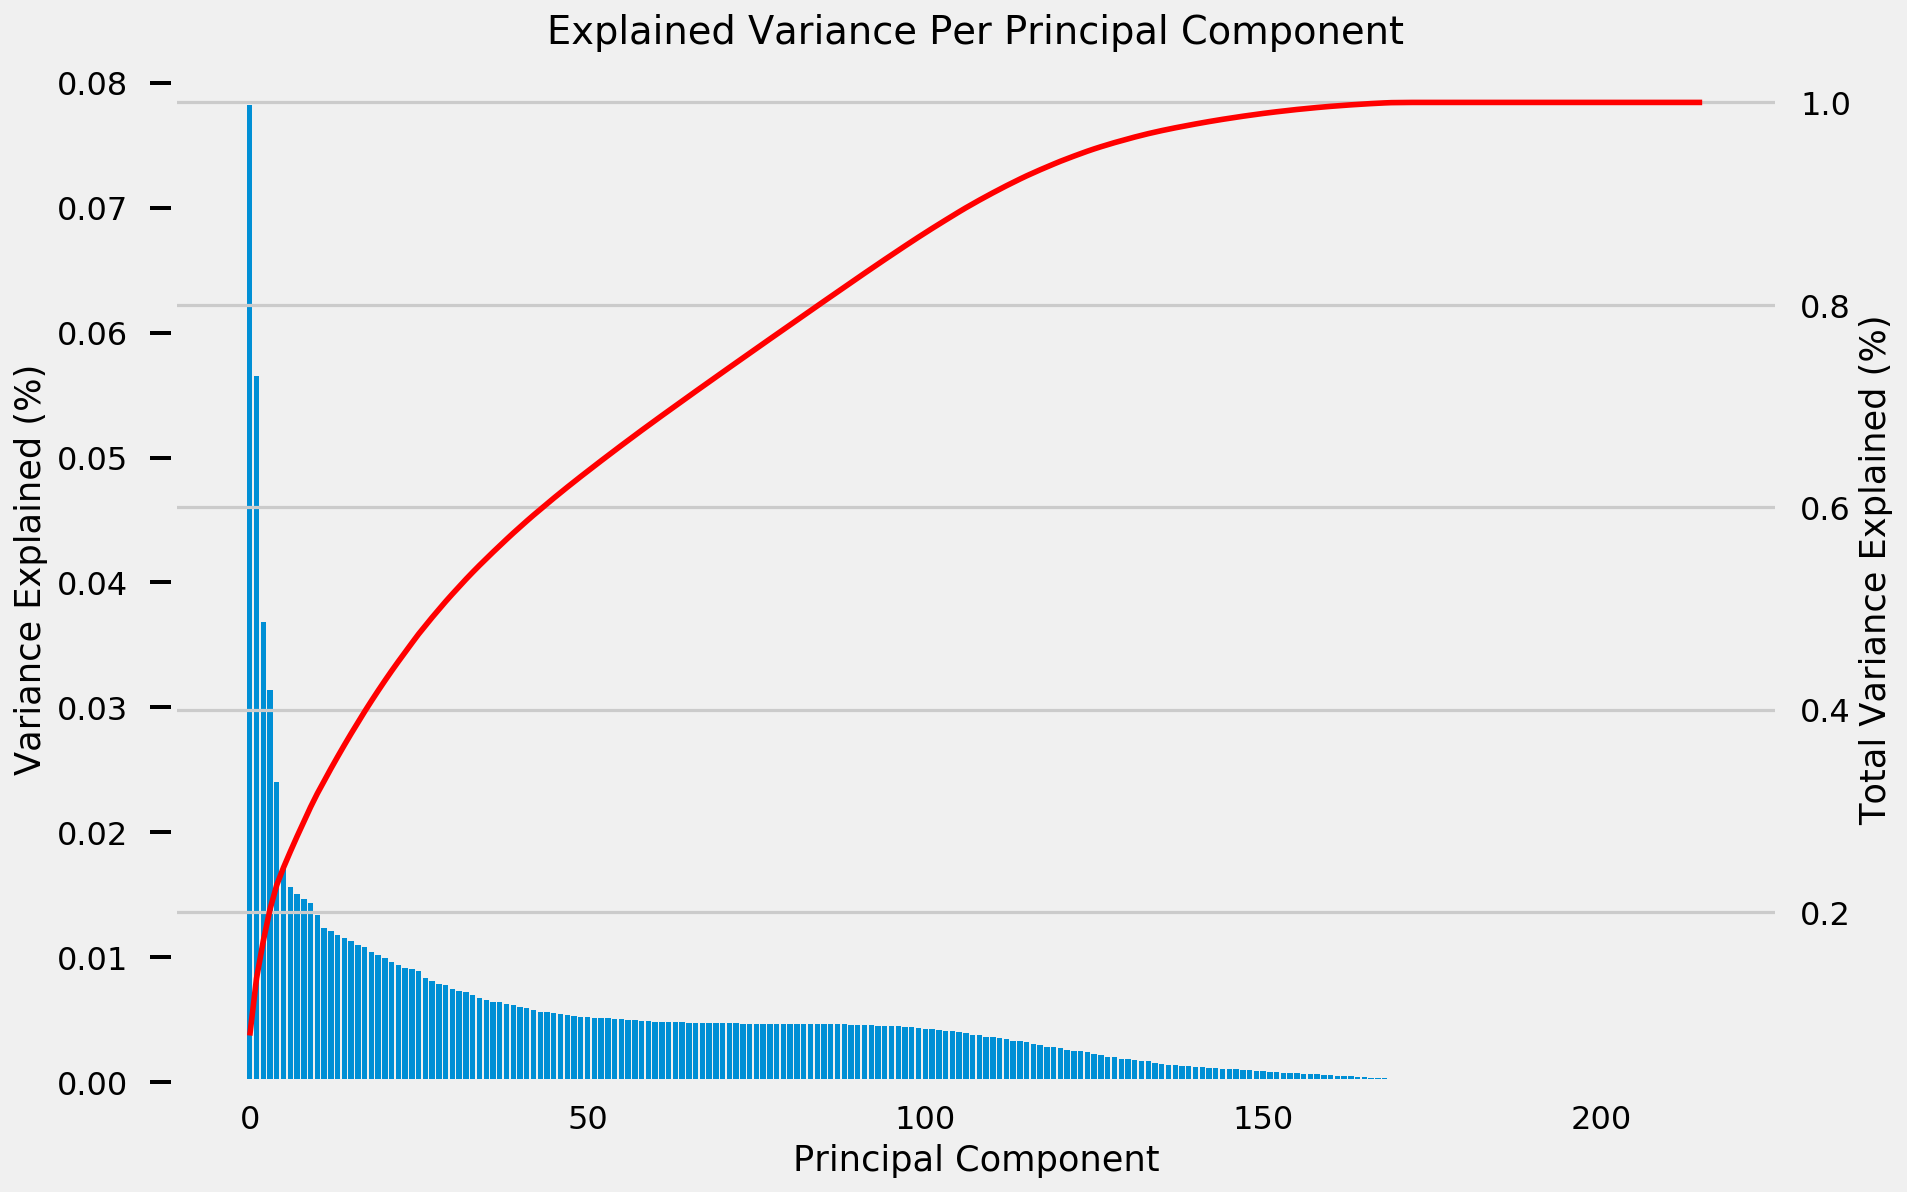

In [51]:
scree_plot(pca)

We can see from the plot that 80% of the variance is explained by fewer than 100 components. I estimated the cutoff to be approximately 85 components.

In [52]:
# Re-apply PCA to the data while selecting for number of components to retain.

# Approximately 85 components explain 80% of the variance
pca_85 = PCA(n_components=85)
azdias_pca = pca_85.fit_transform(azdias_scaled)

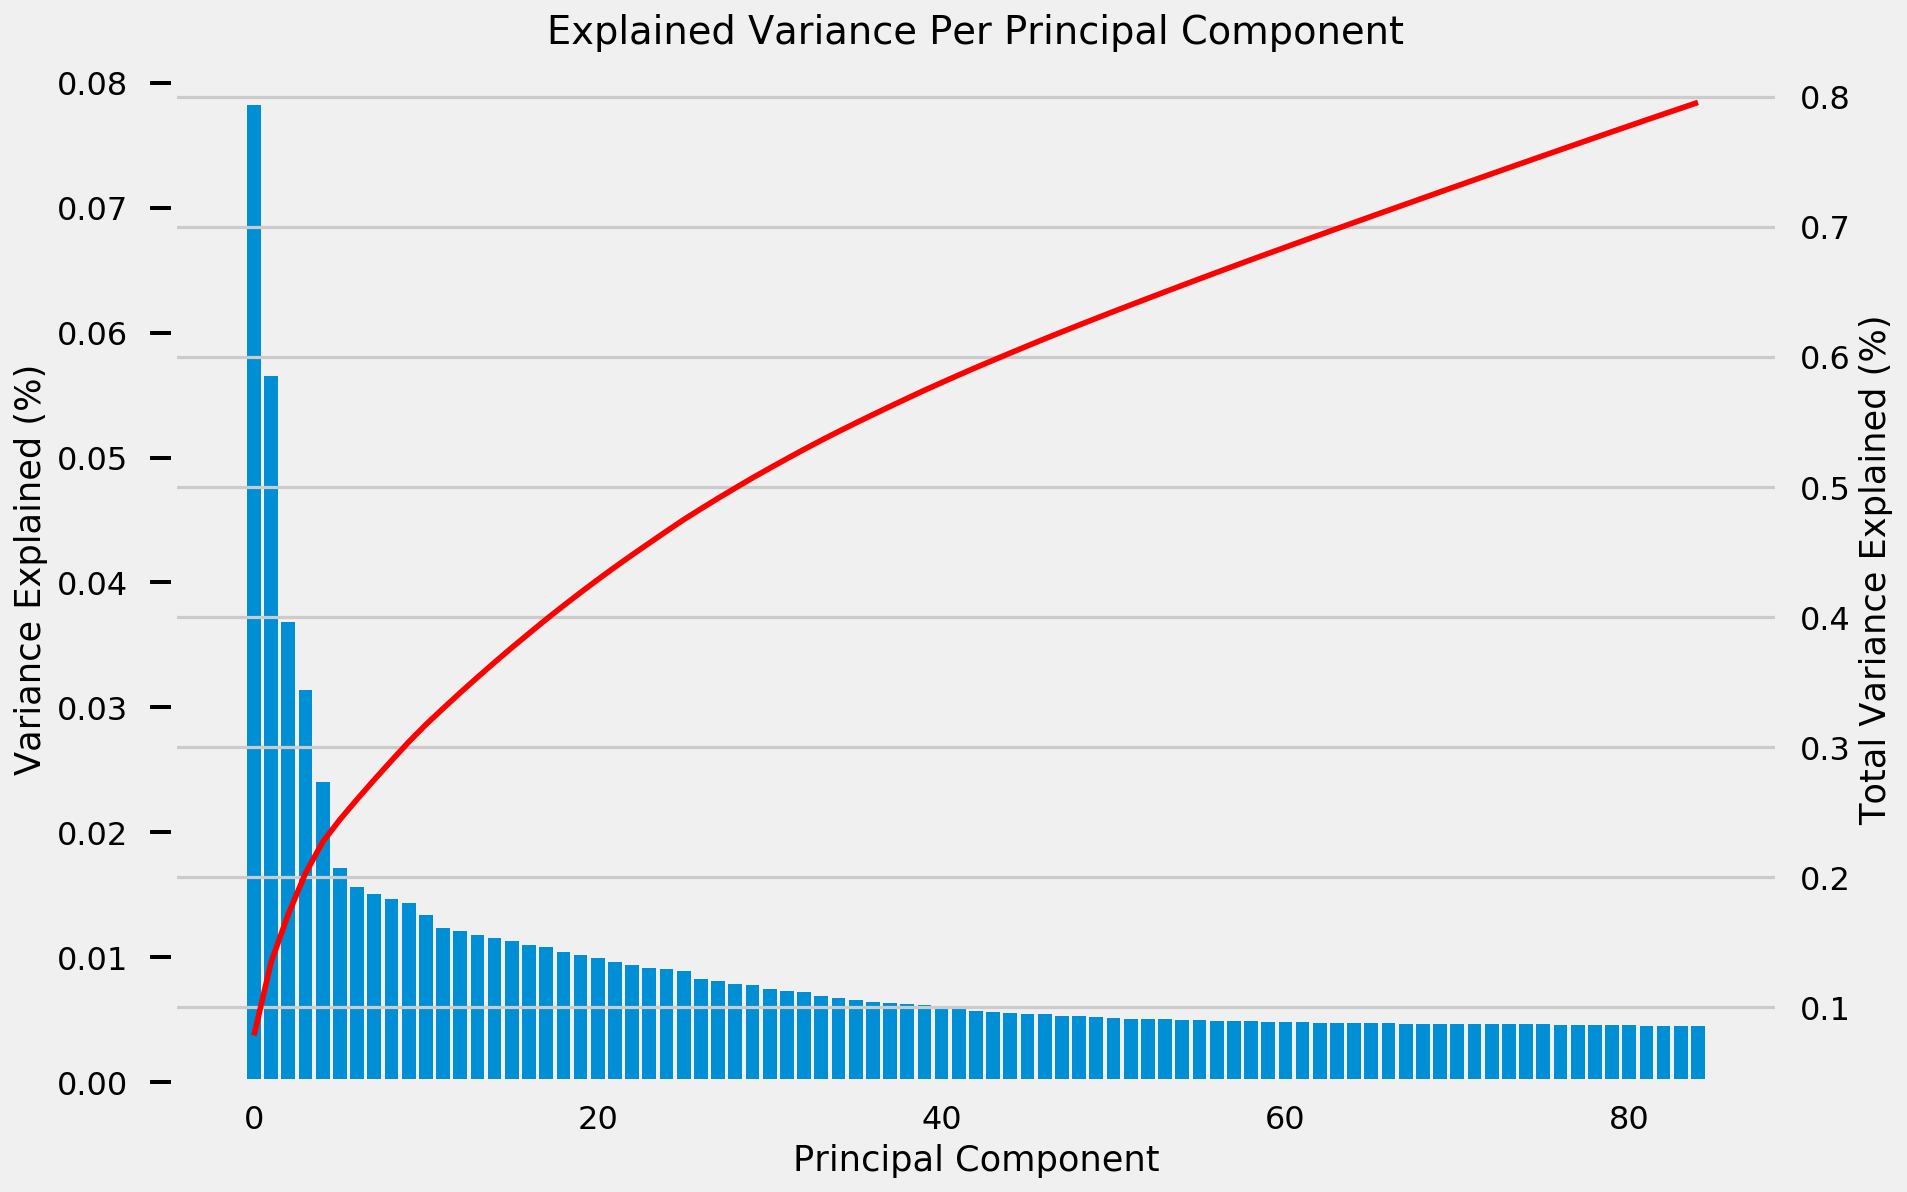

In [53]:
scree_plot(pca_85)

After re-applying PCA with 85 components, I can see that my estimate was quite close - these 85 components explain almost 80% of the variance.

In [54]:
# I borrowed this function from the practice project helper functions
def pca_results(full_dataset, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(
        i) for i in range(1, len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(
        np.round(pca.components_, 4), columns=full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(
        np.round(ratios, 4), columns=['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize=(14, 8))

    # Plot the feature weights as a function of the components
    components.plot(ax=ax, kind='bar')
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)

    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05,
                "Explained Variance\n          %.4f" % (ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis=1)


Explained Variance  ALTERSKATEGORIE_GROB  ALTER_HH  \
Dimension 1               0.0782               -0.0721    0.0091   
Dimension 2               0.0565                0.2311   -0.1793   
Dimension 3               0.0369                0.0174   -0.0321   
Dimension 4               0.0314               -0.0283    0.0559   
Dimension 5               0.0240                0.0497    0.0743   
Dimension 6               0.0172               -0.0019   -0.0035   
Dimension 7               0.0156                0.0114    0.0160   
Dimension 8               0.0151                0.0199    0.0439   
Dimension 9               0.0146               -0.0033   -0.0049   
Dimension 10              0.0144               -0.0093   -0.0357   
Dimension 11              0.0134               -0.0007    0.0535   
Dimension 12              0.0124                0.0150   -0.0629   
Dimension 13              0.0121                0.0075   -0.0833   
Dimension 14              0.0118                0.0473    0.0149   
Dimension 15              0.0116                0.0367   -0.0159   
Dimension 16              0.0113                0.0032   -0.0205   
Dimension 17              0.0110               -0.0186   -0.0399   
Dimension 18              0.0108               -0.1068   -0.0972   
Dimension 19              0.0104               -0.0336   -0.0280   
Dimension 20              0.0102               -0.0141   -0.0142   
Dimension 21              0.0099                0.0056    0.0175   
Dimension 22              0.0096                0.0230   -0.0367   
Dimension 23              0.0094                0.0085   -0.0131   
Dimension 24              0.0091                0.0518    0.0731   
Dimension 25              0.0091                0.0371    0.0116   
Dimension 26              0.0089               -0.0261   -0.0247   
Dimension 27              0.0083               -0.0358   -0.0477   
Dimension 28              0.0081                0.0366   -0.0319   
Dimension 29              0.0079               -0.0301   -0.0712   
Dimension 30              0.0078               -0.0844   -0.0869   
Dimension 31              0.0074               -0.0229   -0.0128   
Dimension 32              0.0073                0.0111    0.0805   
Dimension 33              0.0072               -0.0069    0.0213   
Dimension 34              0.0069               -0.0698    0.0194   
Dimension 35              0.0067               -0.0048   -0.0719   
Dimension 36              0.0066                0.0619    0.0736   
Dimension 37              0.0064               -0.0331   -0.1012   
Dimension 38              0.0064               -0.0487   -0.0758   
Dimension 39              0.0062               -0.0377   -0.1814   
Dimension 40              0.0062                0.0190   -0.0076   
Dimension 41              0.0059                0.0349   -0.0099   
Dimension 42              0.0059                0.0486   -0.0341   
Dimension 43              0.0057               -0.0326   -0.0533   
Dimension 44              0.0056                0.0308    0.0081   
Dimension 45              0.0056               -0.0482   -0.0477   
Dimension 46              0.0055                0.0412    0.0307   
Dimension 47              0.0055               -0.0547    0.0522   
Dimension 48              0.0053                0.0540   -0.0924   
Dimension 49              0.0053                0.0455   -0.0074   
Dimension 50              0.0052               -0.0049    0.0478   
Dimension 51              0.0051                0.0413    0.0246   
Dimension 52              0.0051               -0.0328    0.0374   
Dimension 53              0.0051                0.0018    0.0603   
Dimension 54              0.0050               -0.0321   -0.0539   
Dimension 55              0.0050                0.0103    0.0236   
Dimension 56              0.0050               -0.0380    0.0029   
Dimension 57              0.0049               -0.0086   -0.0446   
Dimension 58              0.0049               -0.0210   -0.0096   
Di

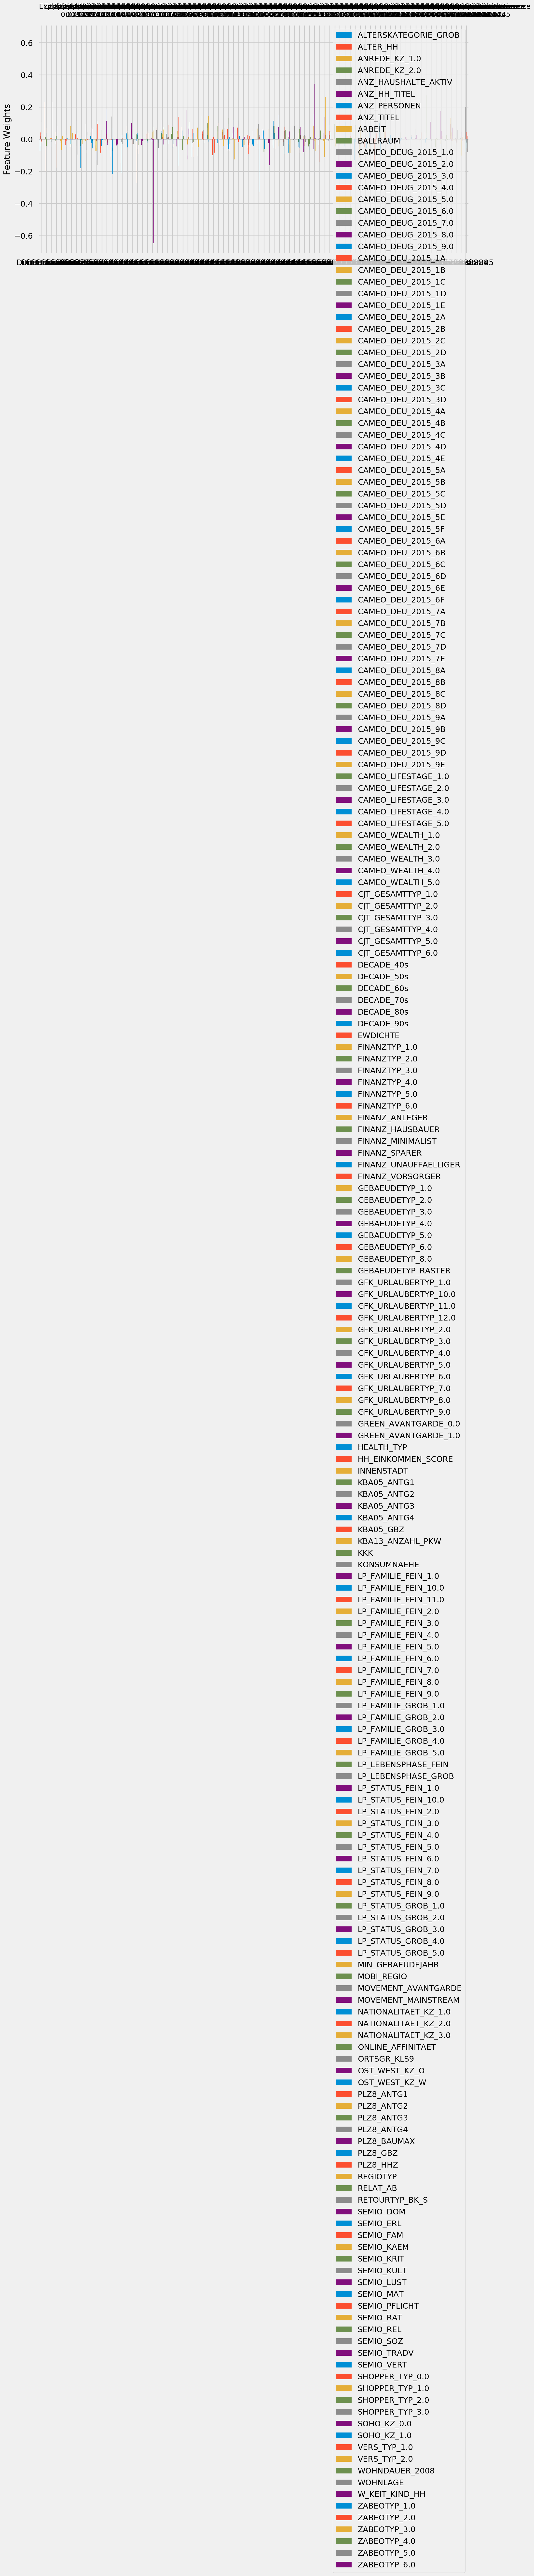

In [55]:
pca_results(azdias_scaled, pca_85)

### Discussion 2.2: Perform Dimensionality Reduction

I reduced the PCA to 85 components based on the 80-20 rule: they explained 80% of the variation.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [56]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# I borrowed this function from the helper functions used in the practice projects
def pca_weight(pca, df, i):
    '''
    INPUT:
        pca - the result of instantiation of PCA in scikit learn
        df - associated dataframe
        i - component reference (zero-based) 
    OUTPUT:
        df - dataframe of linked values, sorted by weight
    '''
    df = pd.DataFrame(pca.components_, columns=list(df.columns))
    weights = df.iloc[i].sort_values(ascending=False)
    return weights

In [57]:
pca_wgt_0 = pca_weight(pca_85, azdias_scaled, 0)
print(pca_wgt_0)

LP_STATUS_GROB_1.0      0.184073
HH_EINKOMMEN_SCORE      0.179633
PLZ8_ANTG3              0.171112
PLZ8_ANTG4              0.166500
PLZ8_BAUMAX             0.163261
CAMEO_WEALTH_5.0        0.144780
ORTSGR_KLS9             0.142604
EWDICHTE                0.140808
FINANZ_HAUSBAUER        0.140388
CAMEO_LIFESTAGE_1.0     0.134500
LP_STATUS_FEIN_1.0      0.128207
KBA05_ANTG4             0.123024
PLZ8_ANTG2              0.116421
KBA05_ANTG3             0.112348
ANZ_HAUSHALTE_AKTIV     0.110638
GREEN_AVANTGARDE_0.0    0.109869
ARBEIT                  0.108635
CAMEO_DEUG_2015_9.0     0.108201
MOVEMENT_MAINSTREAM     0.104953
LP_STATUS_FEIN_2.0      0.100443
RELAT_AB                0.099671
LP_FAMILIE_FEIN_1.0     0.095826
LP_FAMILIE_GROB_1.0     0.095826
FINANZTYP_1.0           0.095817
FINANZ_SPARER           0.095509
CAMEO_DEUG_2015_8.0     0.090891
ZABEOTYP_5.0            0.072074
SEMIO_PFLICHT           0.066241
GEBAEUDETYP_3.0         0.062474
CAMEO_DEU_2015_8A       0.062344
SEMIO_REL 

In [58]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_wgt_1 = pca_weight(pca_85, azdias_scaled, 1)
print(pca_wgt_1)


ALTERSKATEGORIE_GROB     0.231065
FINANZ_VORSORGER         0.214624
ZABEOTYP_3.0             0.194211
SEMIO_ERL                0.179393
SEMIO_LUST               0.164313
RETOURTYP_BK_S           0.153375
W_KEIT_KIND_HH           0.123573
DECADE_60s               0.110940
CJT_GESAMTTYP_2.0        0.105913
DECADE_50s               0.102949
FINANZ_MINIMALIST        0.095445
FINANZTYP_2.0            0.094562
FINANZTYP_5.0            0.091111
LP_STATUS_FEIN_1.0       0.080734
FINANZ_HAUSBAUER         0.076755
SEMIO_KRIT               0.071891
NATIONALITAET_KZ_1.0     0.068755
CJT_GESAMTTYP_1.0        0.068359
DECADE_40s               0.067847
SHOPPER_TYP_3.0          0.067745
FINANZTYP_6.0            0.064956
DECADE_70s               0.058517
LP_FAMILIE_FEIN_1.0      0.058040
LP_FAMILIE_GROB_1.0      0.058040
GFK_URLAUBERTYP_4.0      0.054983
WOHNDAUER_2008           0.054773
SEMIO_KAEM               0.052859
EWDICHTE                 0.050167
ORTSGR_KLS9              0.049229
PLZ8_ANTG3    

In [59]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_wgt_2 = pca_weight(pca_85, azdias_scaled, 2)
print(pca_wgt_2)


ANREDE_KZ_1.0            0.312272
SEMIO_VERT               0.287605
SEMIO_FAM                0.236336
SEMIO_SOZ                0.230526
SEMIO_KULT               0.228507
FINANZTYP_5.0            0.129249
FINANZ_MINIMALIST        0.113591
SEMIO_REL                0.111111
ZABEOTYP_1.0             0.109823
GREEN_AVANTGARDE_1.0     0.109483
MOVEMENT_AVANTGARDE      0.109483
SHOPPER_TYP_0.0          0.102081
ORTSGR_KLS9              0.082681
EWDICHTE                 0.082532
SEMIO_MAT                0.081126
LP_STATUS_FEIN_10.0      0.077530
LP_STATUS_GROB_5.0       0.077530
RETOURTYP_BK_S           0.073105
PLZ8_ANTG3               0.056061
PLZ8_BAUMAX              0.055982
W_KEIT_KIND_HH           0.055873
PLZ8_ANTG4               0.054731
LP_STATUS_FEIN_3.0       0.049804
SHOPPER_TYP_1.0          0.046983
PLZ8_ANTG2               0.043178
ZABEOTYP_6.0             0.042737
RELAT_AB                 0.042639
FINANZ_VORSORGER         0.039343
ARBEIT                   0.038662
LP_STATUS_FEIN

### Discussion 2.3: Interpret Principal Components

The positive and negative values represent how much the features are weighted in the component - the higher the value, the more they are correlated with the component, and the lower the value the more they are anti-correlated. For example in component 0 we see `LP_STATUS_GROB_1.0` is the hightest weighted feature. That's a one-hot encoded variable that we know represents low-income earners.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [60]:
def plot_data(data, labels):
    '''
    Plot data with colors associated with labels
    '''
    fig = plt.figure();
    ax = Axes3D(fig)
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels, cmap='tab10');


In [ ]:
# Over a number of different cluster counts...
kmeans = KMeans(n_clusters=3)

# run k-means clustering on the data and...
model = kmeans.fit(azdias_pca)    
azdias_predict = model.predict(azdias_pca)
plot_data(azdias_pca, azdias_predict)

# compute the average within-cluster distances.
    
    

In [ ]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

# Borrowed from the practice project helper functions
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

scores = []
centers = list(range(1,21))

for center in centers:
    scores.append(get_kmeans_score(azdias_pca, center))

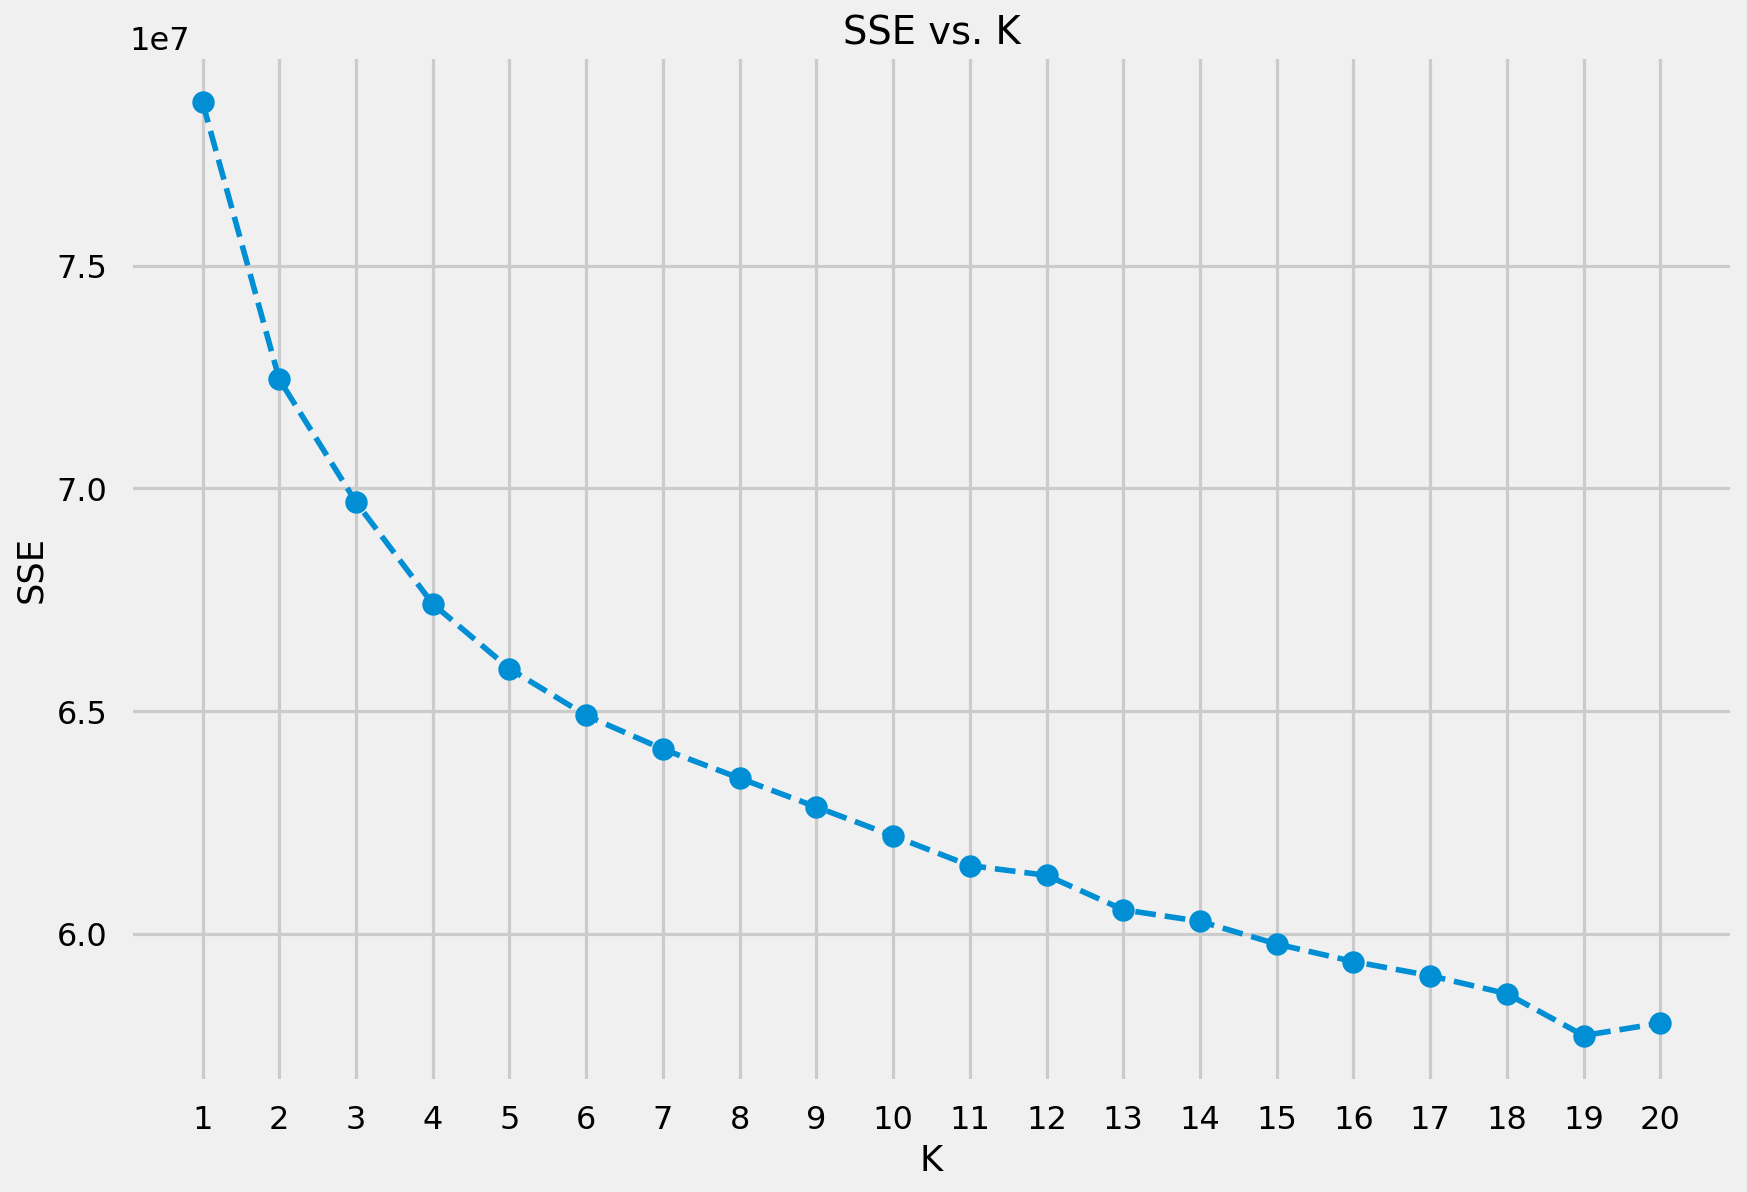

In [63]:
plt.plot(centers, scores, linestyle='--', marker='o')
plt.xlabel('K')
plt.xticks(centers)
plt.ylabel('SSE')
plt.title('SSE vs. K')
plt.show()

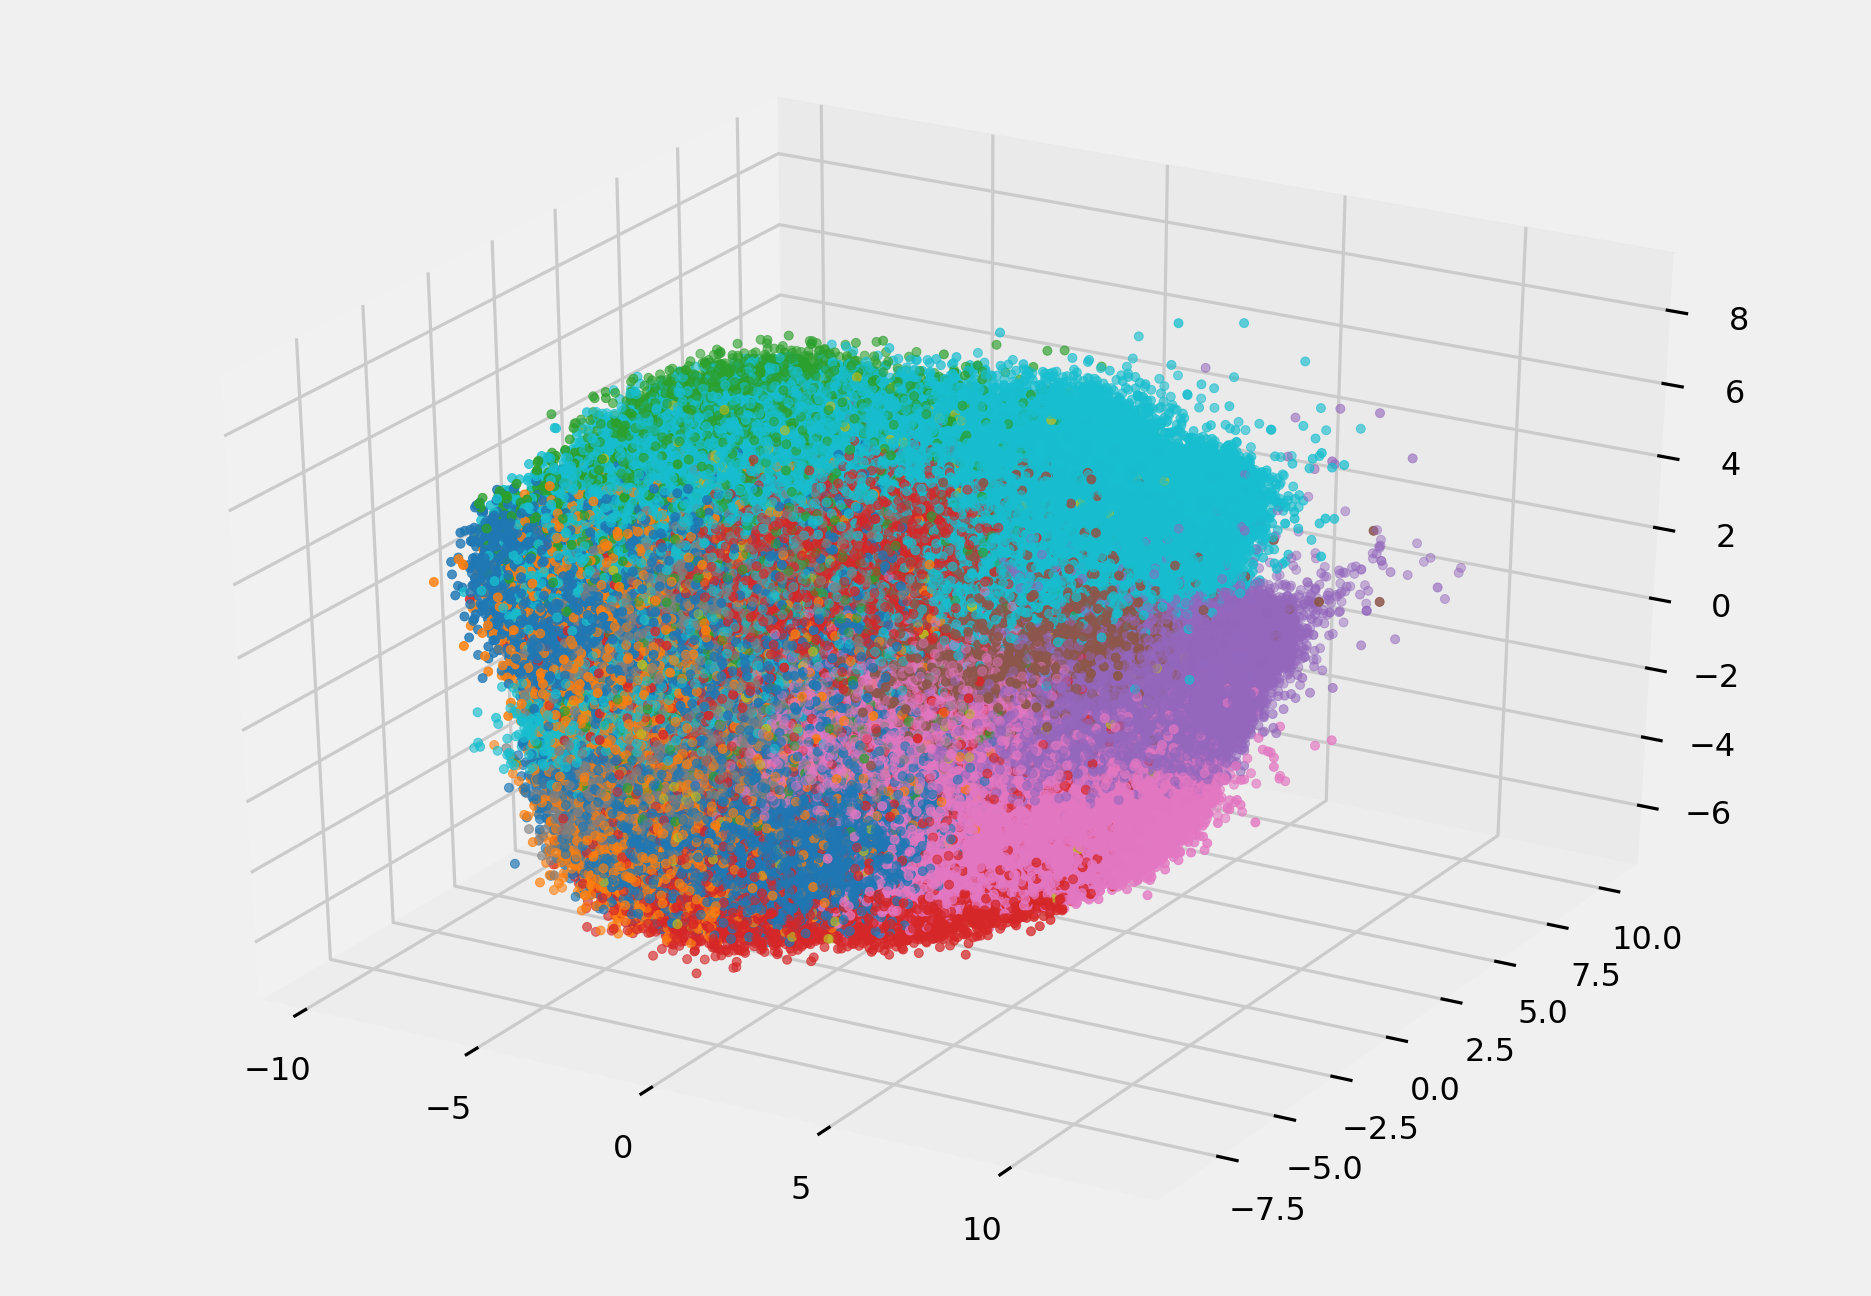

In [61]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=14)

# run k-means clustering on the data and...
model = kmeans.fit(azdias_pca)    
azdias_predict = model.predict(azdias_pca)
plot_data(azdias_pca, azdias_predict)

### Discussion 3.1: Apply Clustering to General Population

The elbow of the scree plot is at approximately 14 so I selected that as the number of clusters in my k-means model. We can see a neat 3D visual representation of some of those clusters above. I saw some, because obviously several clusters will be hidden from any direction in a 3D view.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [62]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [63]:
# Clean the data
customers_cleaned = clean_data(customers, feat_info)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [64]:
customers_cleaned.shape

(142538, 215)

In [65]:
# We're missing one column, figure out what it is
set(azdias_scaled.columns).difference(customers_cleaned.columns)

{'GEBAEUDETYP_5.0'}

In [66]:
# It's a one-hot encoded column that's missing, so we can safely set it to 0
customers_cleaned['GEBAEUDETYP_5.0'] = 0

In [67]:
# Replace missing values with median

customers_cleaned[[
    'ALTER_HH', 'KKK', 'REGIOTYP', 'W_KEIT_KIND_HH', 'KBA05_ANTG2',
    'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'MOBI_REGIO', 'KBA05_ANTG1',
    'PLZ8_BAUMAX', 'PLZ8_ANTG2', 'PLZ8_HHZ', 'PLZ8_GBZ', 'PLZ8_ANTG4',
    'PLZ8_ANTG3', 'PLZ8_ANTG1', 'KBA13_ANZAHL_PKW', 'LP_LEBENSPHASE_FEIN',
    'LP_LEBENSPHASE_GROB', 'ANZ_HAUSHALTE_AKTIV', 'RELAT_AB', 'ARBEIT',
    'ORTSGR_KLS9', 'ANZ_HH_TITEL', 'EWDICHTE', 'BALLRAUM', 'INNENSTADT',
    'GEBAEUDETYP_RASTER', 'WOHNLAGE', 'MIN_GEBAEUDEJAHR', 'HH_EINKOMMEN_SCORE',
    'RETOURTYP_BK_S', 'ONLINE_AFFINITAET', 'KONSUMNAEHE'
]] = impute.fit_transform(customers_cleaned[[
    'ALTER_HH', 'KKK', 'REGIOTYP', 'W_KEIT_KIND_HH', 'KBA05_ANTG2',
    'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'MOBI_REGIO', 'KBA05_ANTG1',
    'PLZ8_BAUMAX', 'PLZ8_ANTG2', 'PLZ8_HHZ', 'PLZ8_GBZ', 'PLZ8_ANTG4',
    'PLZ8_ANTG3', 'PLZ8_ANTG1', 'KBA13_ANZAHL_PKW', 'LP_LEBENSPHASE_FEIN',
    'LP_LEBENSPHASE_GROB', 'ANZ_HAUSHALTE_AKTIV', 'RELAT_AB', 'ARBEIT',
    'ORTSGR_KLS9', 'ANZ_HH_TITEL', 'EWDICHTE', 'BALLRAUM', 'INNENSTADT',
    'GEBAEUDETYP_RASTER', 'WOHNLAGE', 'MIN_GEBAEUDEJAHR', 'HH_EINKOMMEN_SCORE',
    'RETOURTYP_BK_S', 'ONLINE_AFFINITAET', 'KONSUMNAEHE'
]])

In [68]:
customers_scaled = pd.DataFrame(scaler.fit_transform(customers_cleaned))

In [69]:
customers_scaled.columns = customers_cleaned.columns
customers_scaled.index = customers_cleaned.index
customers_scaled = pd.DataFrame(customers_scaled, columns=list(customers_cleaned))

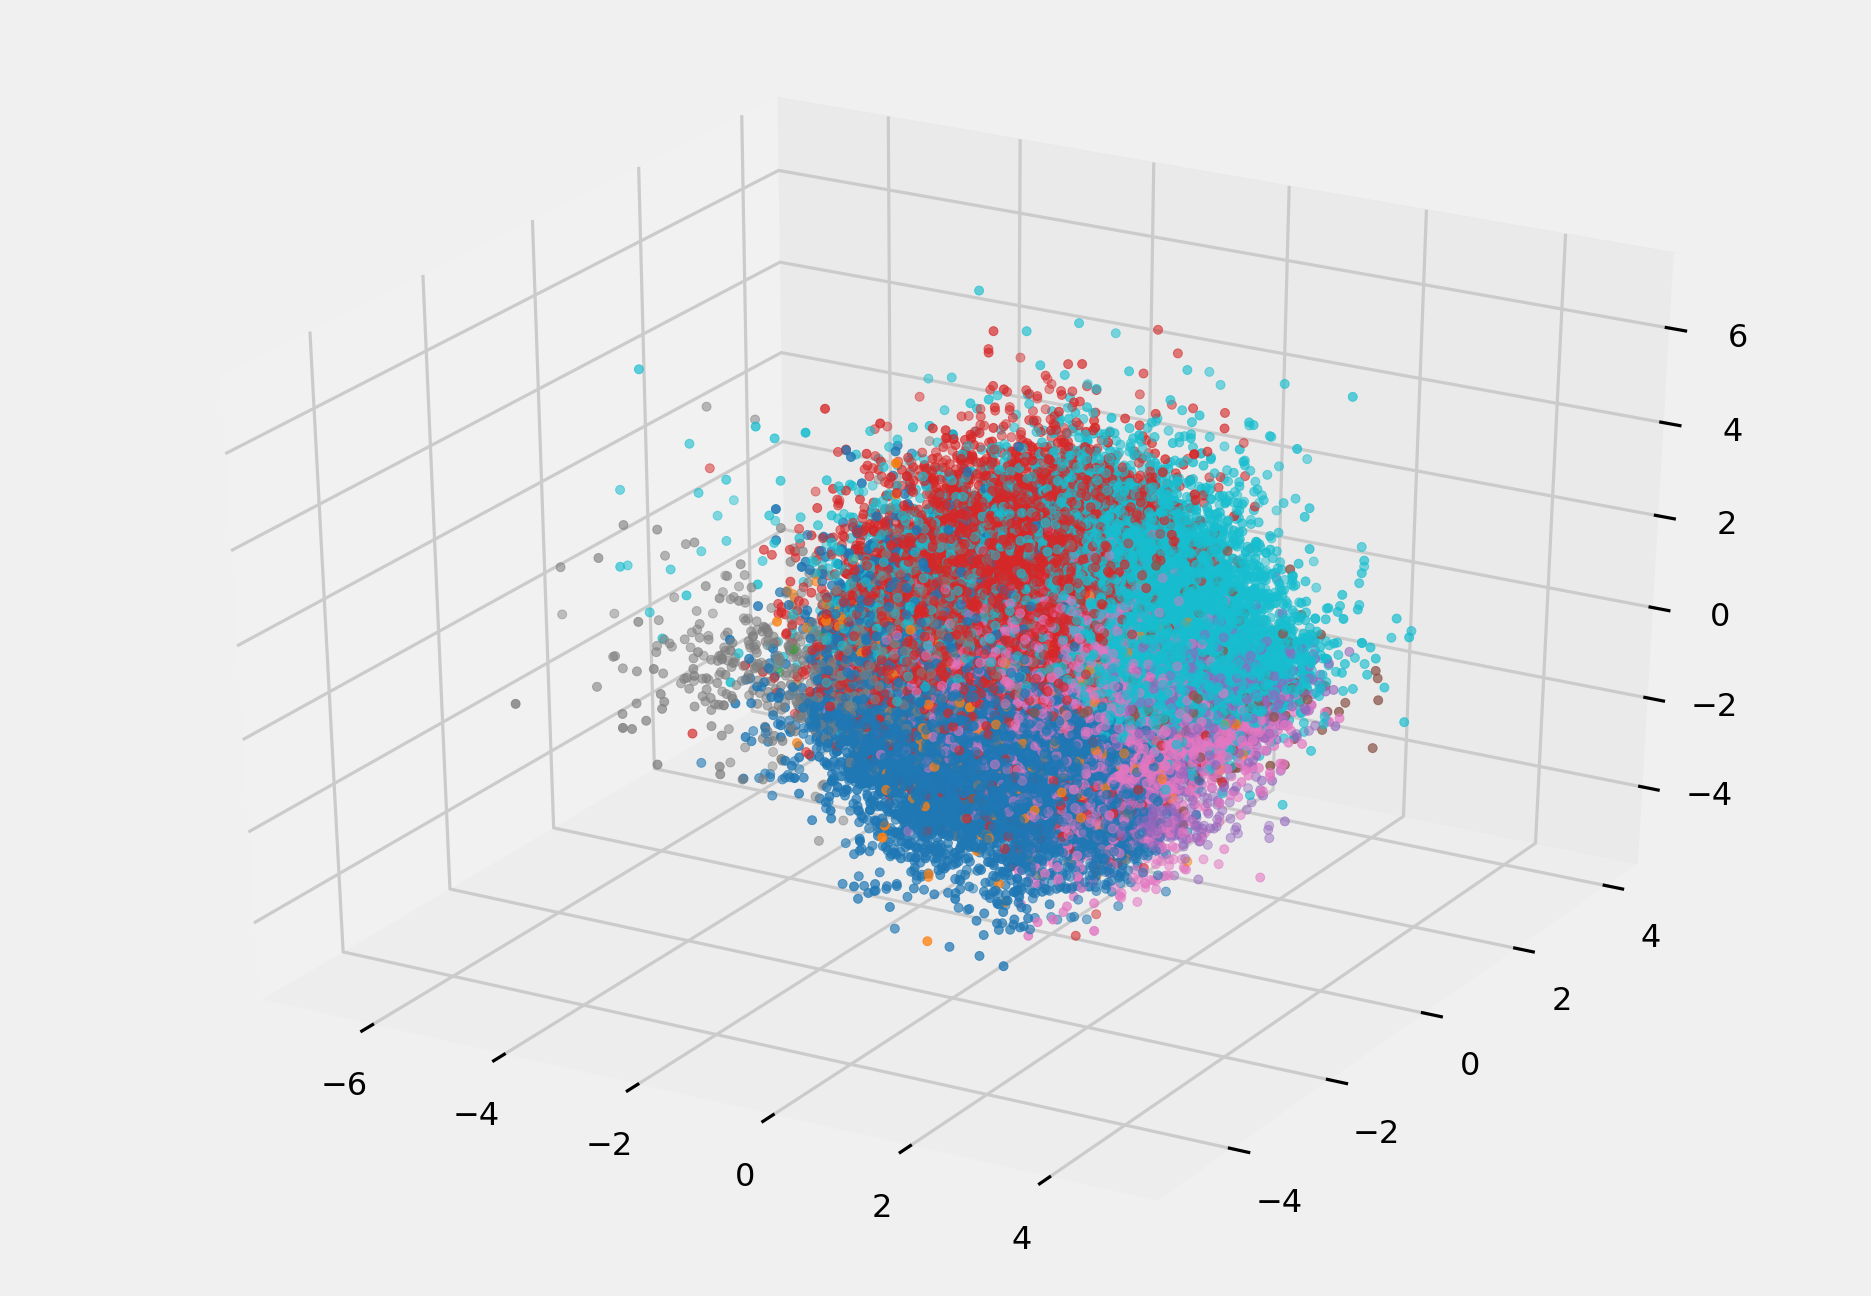

In [70]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# run k-means clustering on the data and...
customers_pca = pca_85.transform(customers_scaled)
customers_predict = model.predict(customers_pca)
plot_data(customers_pca, customers_predict)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5, 1.0, 'General Clusters')

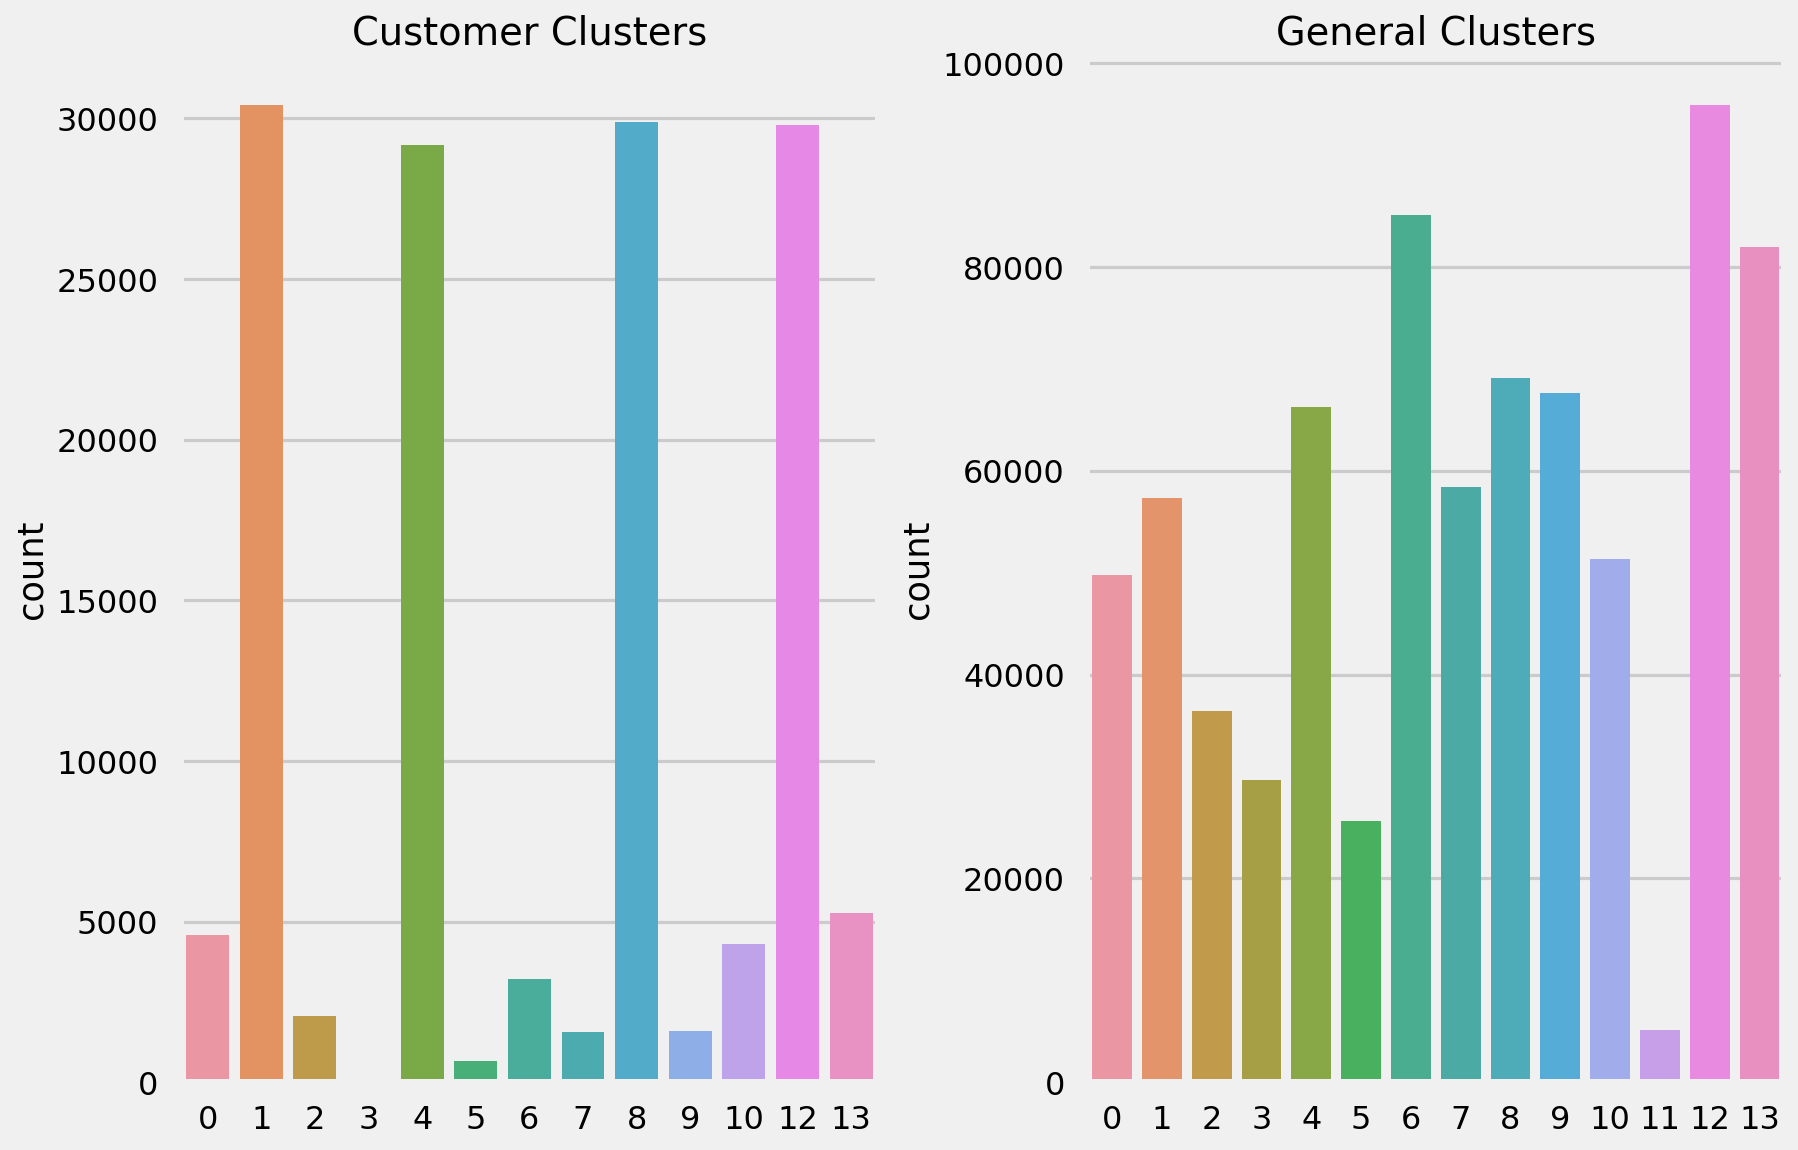

In [71]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

figure, axs = plt.subplots(nrows=1, ncols=2)
figure.subplots_adjust(hspace=1, wspace=.3)

sns.countplot(customers_predict, ax=axs[0])
axs[0].set_title('Customer Clusters')
sns.countplot(azdias_predict, ax=axs[1])
axs[1].set_title('General Clusters')


In [72]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Cluster 1 is overrepresented

centroid_1 = scaler.inverse_transform(pca_85.inverse_transform(model.cluster_centers_[1]))
overrepresented_1 = pd.Series(data = centroid_1, index = customers_scaled.columns)

In [73]:
pca_wgt_1 = pca_weight(pca_85, customers_scaled, 1)
print(pca_wgt_1)

ALTERSKATEGORIE_GROB    0.231065
LP_FAMILIE_FEIN_2.0     0.214624
CAMEO_LIFESTAGE_3.0     0.194211
CAMEO_DEU_2015_6B       0.179393
CAMEO_DEU_2015_7A       0.164313
CAMEO_DEU_2015_5F       0.153375
CAMEO_WEALTH_5.0        0.123573
FINANZTYP_6.0           0.110940
CJT_GESAMTTYP_5.0       0.105913
FINANZTYP_5.0           0.102949
GREEN_AVANTGARDE_0.0    0.095445
GFK_URLAUBERTYP_6.0     0.094562
GFK_URLAUBERTYP_9.0     0.091111
GEBAEUDETYP_8.0         0.080734
GFK_URLAUBERTYP_12.0    0.076755
CAMEO_DEU_2015_6E       0.071891
CAMEO_DEU_2015_2C       0.068755
CJT_GESAMTTYP_4.0       0.068359
FINANZTYP_4.0           0.067847
CAMEO_DEU_2015_9C       0.067745
GFK_URLAUBERTYP_10.0    0.064956
GFK_URLAUBERTYP_1.0     0.058517
SHOPPER_TYP_1.0         0.058040
ZABEOTYP_5.0            0.058040
LP_STATUS_FEIN_1.0      0.054983
CAMEO_WEALTH_3.0        0.054773
CAMEO_DEU_2015_6D       0.052859
GFK_URLAUBERTYP_4.0     0.050167
CAMEO_DEU_2015_3C       0.049229
CAMEO_DEU_2015_4D       0.048389
CAMEO_DEUG

In [74]:
cluster_specs = pd.DataFrame(scaler.inverse_transform(pca_85.inverse_transform(
    model.cluster_centers_)), columns=customers_cleaned.columns)
cluster_1 = cluster_specs.iloc[1]
pd.DataFrame(dict(cluster_1=cluster_1, pca_wgt_1=pca_wgt_1)
             ).reset_index().sort_values(by='pca_wgt_1', ascending=False)


index  cluster_1  pca_wgt_1
0    ALTERSKATEGORIE_GROB   2.806248   0.231065
134   LP_FAMILIE_FEIN_2.0  -0.182716   0.214624
65    CAMEO_LIFESTAGE_3.0  -0.091304   0.194211
44      CAMEO_DEU_2015_6B   0.038900   0.179393
49      CAMEO_DEU_2015_7A  -0.084237   0.164313
42      CAMEO_DEU_2015_5F  -0.056220   0.153375
72       CAMEO_WEALTH_5.0   0.055079   0.123573
91          FINANZTYP_6.0   0.114501   0.110940
77      CJT_GESAMTTYP_5.0  -0.003532   0.105913
90          FINANZTYP_5.0   0.160996   0.102949
118  GREEN_AVANTGARDE_0.0   0.110379   0.095445
114   GFK_URLAUBERTYP_6.0  -0.030637   0.094562
117   GFK_URLAUBERTYP_9.0  -0.048653   0.091111
104       GEBAEUDETYP_8.0  -0.024426   0.080734
109  GFK_URLAUBERTYP_12.0   0.044817   0.076755
47      CAMEO_DEU_2015_6E   0.105449   0.071891
26      CAMEO_DEU_2015_2C  -0.003980   0.068755
76      CJT_GESAMTTYP_4.0   0.178537   0.068359
89          FINANZTYP_4.0  -0.007966   0.067847
60      CAMEO_DEU_2015_9C   0.007354   0.067745
107  GFK_URLAUBERTYP_10.0   0.000014   0.064956
106   GFK_URLAUBERTYP_1.0  -0.052506   0.058517
214          ZABEOTYP_5.0   0.013276   0.058040
200       SHOPPER_TYP_1.0   0.297010   0.058040
149    LP_STATUS_FEIN_1.0   0.049022   0.054983
70       CAMEO_WEALTH_3.0   0.008167   0.054773
46      CAMEO_DEU_2015_6D   0.074764   0.052859
112   GFK_URLAUBERTYP_4.0  -0.046796   0.050167
30      CAMEO_DEU_2015_3C  -0.064562   0.049229
35      CAMEO_DEU_2015_4D  -0.051400   0.048389
10    CAMEO_DEUG_2015_1.0   0.071498   0.047261
36      CAMEO_DEU_2015_4E  -0.043862   0.045279
37      CAMEO_DEU_2015_5A  -0.049633   0.044513
153    LP_STATUS_FEIN_4.0   0.014007   0.043657
166   MOVEMENT_AVANTGARDE   0.427352   0.043517
163    LP_STATUS_GROB_5.0   0.191659   0.040793
147   LP_LEBENSPHASE_FEIN  20.330483   0.039883
203           SOHO_KZ_0.0   0.983080   0.039450
215          ZABEOTYP_6.0   0.025189   0.039450
97       FINANZ_VORSORGER   5.395484   0.038775
92         FINANZ_ANLEGER   1.311648   0.037490
41      CAMEO_DEU_2015_5E  -0.016310   0.036486
81             DECADE_60s   0.208455   0.035830
75      CJT_GESAMTTYP_3.0  -0.012400   0.035069
34      CAMEO_DEU_2015_4C  -0.018224   0.034579
8                  ARBEIT   2.692589   0.032519
146   LP_FAMILIE_GROB_5.0   0.356910   0.031307
186             SEMIO_ERL   4.291714   0.031205
43      CAMEO_DEU_2015_6A   0.059860   0.027200
150   LP_STATUS_FEIN_10.0   0.322185   0.025429
..                    ...        ...        ...
160    LP_STATUS_GROB_2.0   0.266745  -0.036716
38      CAMEO_DEU_2015_5B   0.058323  -0.037068
78      CJT_GESAMTTYP_6.0   0.120701  -0.037162
22      CAMEO_DEU_2015_1D   0.077270  -0.037896
212          ZABEOTYP_3.0   0.343233  -0.038092
199       SHOPPER_TYP_0.0   0.370812  -0.038731
95          FINANZ_SPARER   0.618640  -0.038775
159    LP_STATUS_GROB_1.0   0.270475  -0.039226
144   LP_FAMILIE_GROB_3.0   0.019999  -0.039641
211          ZABEOTYP_2.0   0.023783  -0.040836
101       GEBAEUDETYP_4.0  -0.004003  -0.040936
145   LP_FAMILIE_GROB_4.0   0.100352  -0.042408
88          FINANZTYP_3.0   0.106390  -0.043274
168  NATIONALITAET_KZ_1.0   1.043296  -0.045073
23      CAMEO_DEU_2015_1E   0.089451  -0.045524
98        GEBAEUDETYP_1.0   0.578667  -0.045934
100       GEBAEUDETYP_3.0   0.232319  -0.046156
27      CAMEO_DEU_2015_2D   0.073173  -0.047087
57      CAMEO_DEU_2015_8D  -0.001505  -0.047573
33      CAMEO_DEU_2015_4B   0.077799  -0.047691
28      CAMEO_DEU_2015_3A   0.055939  -0.048632
103       GEBAEUDETYP_6.0  -0.002150  -0.048852
110   GFK_URLAUBERTYP_2.0   0.052975  -0.050648
158    LP_STATUS_FEIN_9.0   0.262861  -0.050794
63    CAMEO_LIFESTAGE_1.0   0.127096  -0.050921
86          FINANZTYP_1.0   0.024600  -0.054688
54      CAMEO_DEU_2015_8A  -0.071245  -0.064676
93       FINANZ_HAUSBAUER   2.800663  -0.064744
99        GEBAEUDETYP_2.0  -0.011293  -0.066929
115   GFK_URLAUBERTYP_7.0   0.132177  -0.069196
155    LP_STATUS_FEIN_6.0   0.086459  -0.071016
12    CAMEO_DEUG_2015_3.0   0.379582

#### Overrepresented Cluster 11: TODO

The strongest positive feature weights: LP_STATUS_GROB_1.0 and HH_EINKOMMEN_SCORE which implies ...
The strongest negative feature weights: INNENSTADT and PLZ8_GBZ which implies ...

```
HIGHLY CORRELATED:

CAMEO_WEALTH_1.0         0.203785
ZABEOTYP_6.0             0.148592
SOHO_KZ_0.0              0.148592
SEMIO_KULT               0.144538
MOVEMENT_AVANTGARDE      0.144150
CAMEO_DEU_2015_4A        0.138890
RETOURTYP_BK_S           0.127785
DECADE_90s               0.126151
FINANZ_ANLEGER           0.123606
DECADE_60s               0.122540
LP_STATUS_GROB_5.0       0.116484
NATIONALITAET_KZ_2.0     0.113176
CAMEO_DEU_2015_9C        0.110296
CAMEO_DEU_2015_1A        0.107498
GFK_URLAUBERTYP_6.0      0.105223
LP_FAMILIE_FEIN_5.0      0.104880
HH_EINKOMMEN_SCORE       0.098611
FINANZ_UNAUFFAELLIGER    0.097401
CAMEO_DEU_2015_5C        0.096106

ANTI-CORRELATED:

CAMEO_DEUG_2015_2.0     -0.114769
PLZ8_GBZ                -0.132323
SEMIO_ERL               -0.133626
GFK_URLAUBERTYP_1.0     -0.136684
LP_LEBENSPHASE_FEIN     -0.137703
CAMEO_DEU_2015_3D       -0.156642
CAMEO_DEUG_2015_9.0     -0.159114
LP_STATUS_FEIN_9.0      -0.161246
CAMEO_WEALTH_2.0        -0.203785
GFK_URLAUBERTYP_10.0    -0.207783
MOVEMENT_MAINSTREAM     -0.221223
```

---

In [75]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Cluster 13 is underrepresented

centroid_13 = scaler.inverse_transform(pca_85.inverse_transform(model.cluster_centers_[13]))
underrepresented_c = pd.Series(data = centroid_13, index = customers_cleaned.columns)

In [76]:
pca_wgt_13 = pca_weight(pca_85, customers_scaled, 13)
print(pca_wgt_13)

SEMIO_LUST               0.282200
DECADE_70s               0.272704
CAMEO_WEALTH_1.0         0.230052
KBA13_ANZAHL_PKW         0.225037
PLZ8_ANTG1               0.186010
DECADE_80s               0.169904
ANZ_HH_TITEL             0.148321
OST_WEST_KZ_O            0.124030
CAMEO_DEU_2015_1C        0.124030
CJT_GESAMTTYP_2.0        0.111567
SEMIO_KULT               0.103937
CAMEO_DEU_2015_2A        0.092360
LP_STATUS_FEIN_8.0       0.092360
SEMIO_REL                0.084758
LP_LEBENSPHASE_GROB      0.080493
CAMEO_DEU_2015_9C        0.077077
CAMEO_WEALTH_4.0         0.076189
KBA05_ANTG3              0.069297
CAMEO_DEU_2015_7B        0.067438
DECADE_50s               0.066878
GFK_URLAUBERTYP_6.0      0.064753
CAMEO_DEU_2015_2C        0.061874
RELAT_AB                 0.059166
CAMEO_LIFESTAGE_5.0      0.058943
LP_STATUS_GROB_1.0       0.057648
LP_STATUS_FEIN_4.0       0.053551
KBA05_ANTG2              0.053137
LP_FAMILIE_GROB_3.0      0.050839
SEMIO_TRADV              0.049417
GEBAEUDETYP_3.

In [77]:
cluster_13 = cluster_specs.iloc[13]
pd.DataFrame(dict(cluster_13=cluster_13, pca_wgt_13=pca_wgt_13)
             ).reset_index().sort_values(by='pca_wgt_13', ascending=False)


index  cluster_13  pca_wgt_13
191             SEMIO_LUST    5.198889    0.282200
82              DECADE_70s   -0.001683    0.272704
68        CAMEO_WEALTH_1.0    0.292655    0.230052
128       KBA13_ANZAHL_PKW  618.722360    0.225037
175             PLZ8_ANTG1    2.486379    0.186010
83              DECADE_80s    0.107347    0.169904
5             ANZ_HH_TITEL    0.091900    0.148321
21       CAMEO_DEU_2015_1C    0.256839    0.124030
173          OST_WEST_KZ_O    0.609047    0.124030
74       CJT_GESAMTTYP_2.0    0.191445    0.111567
190             SEMIO_KULT    3.268513    0.103937
157     LP_STATUS_FEIN_8.0    0.148148    0.092360
24       CAMEO_DEU_2015_2A    0.326495    0.092360
195              SEMIO_REL    3.392383    0.084758
148    LP_LEBENSPHASE_GROB    7.129703    0.080493
60       CAMEO_DEU_2015_9C    0.025040    0.077077
71        CAMEO_WEALTH_4.0    0.053148    0.076189
125            KBA05_ANTG3    0.285142    0.069297
50       CAMEO_DEU_2015_7B   -0.028771    0.067438
80              DECADE_50s    0.207896    0.066878
114    GFK_URLAUBERTYP_6.0    0.117116    0.064753
26       CAMEO_DEU_2015_2C    0.084040    0.061874
183               RELAT_AB    2.703269    0.059166
67     CAMEO_LIFESTAGE_5.0    0.061190    0.058943
159     LP_STATUS_GROB_1.0    0.162745    0.057648
153     LP_STATUS_FEIN_4.0    0.082644    0.053551
124            KBA05_ANTG2    1.160446    0.053137
144    LP_FAMILIE_GROB_3.0   -0.024865    0.050839
197            SEMIO_TRADV    3.258117    0.049417
100        GEBAEUDETYP_3.0    0.348215    0.048467
40       CAMEO_DEU_2015_5D   -0.053277    0.048377
170   NATIONALITAET_KZ_3.0   -0.038547    0.048013
49       CAMEO_DEU_2015_7A    0.100569    0.047790
0     ALTERSKATEGORIE_GROB    3.860450    0.047306
44       CAMEO_DEU_2015_6B    0.136211    0.046888
79              DECADE_40s    0.081340    0.045825
178             PLZ8_ANTG4    0.485513    0.045250
77       CJT_GESAMTTYP_5.0    0.183527    0.044859
200        SHOPPER_TYP_1.0    0.075770    0.043884
214           ZABEOTYP_5.0   -0.029374    0.043884
72        CAMEO_WEALTH_5.0    0.113025    0.041787
181               PLZ8_HHZ    3.498926    0.041671
37       CAMEO_DEU_2015_5A   -0.041759    0.041334
172            ORTSGR_KLS9    4.806471    0.040227
91           FINANZTYP_6.0    0.415493    0.039838
115    GFK_URLAUBERTYP_7.0    0.151383    0.037727
22       CAMEO_DEU_2015_1D    0.029604    0.037637
201        SHOPPER_TYP_2.0    0.298146    0.037360
11     CAMEO_DEUG_2015_2.0    0.037428    0.034706
97        FINANZ_VORSORGER    4.524630    0.034687
..                     ...         ...         ...
211           ZABEOTYP_2.0    0.022833   -0.043310
96   FINANZ_UNAUFFAELLIGER    1.794346   -0.043757
107   GFK_URLAUBERTYP_10.0    0.193109   -0.043855
188             SEMIO_KAEM    3.508483   -0.044087
3            ANREDE_KZ_2.0    0.464551   -0.046798
32       CAMEO_DEU_2015_4A    0.116526   -0.048332
43       CAMEO_DEU_2015_6A    0.008764   -0.049769
42       CAMEO_DEU_2015_5F    0.023851   -0.050208
30       CAMEO_DEU_2015_3C    0.043865   -0.051485
66     CAMEO_LIFESTAGE_4.0    0.166509   -0.051768
117    GFK_URLAUBERTYP_9.0    0.079655   -0.051993
127              KBA05_GBZ    3.751733   -0.054328
185              SEMIO_DOM    3.826541   -0.054411
186              SEMIO_ERL    4.233555   -0.054729
193          SEMIO_PFLICHT    2.948062   -0.055517
27       CAMEO_DEU_2015_2D    0.019144   -0.055869
189             SEMIO_KRIT    3.737023   -0.056255
59       CAMEO_DEU_2015_9B   -0.004573   -0.058484
99         GEBAEUDETYP_2.0   -0.009277   -0.058503
129                    KKK    2.398491   -0.061172
8                   ARBEIT    2.680376   -0.061291
19       CAMEO_DEU_2015_1A    0.047072   -0.061306
196              SEMIO_SOZ    5.595245   -0.061575
171      ONLINE_AFFINITAET    2.779042   -0.062372
14     CAMEO_DEUG_2015_5.0    0.105976   -0.062511
104        GEBAEUDETYP_8.0   -0.047717   -0.063626
203            SOHO_KZ_0.0    1.015536   -0

#### Underrepresented Cluster 13: TODO


```
HIGHLY CORRELATED:

```

### Discussion 3.3: Compare Customer Data to Demographics Data

We can draw some conclusions about the types of customers that are more popular with the mail-order company: they're more likely to be women, urban, in their thirties, and higher income. Based on this analysis we can imagine some specific marketing and advertising campaigns directed at these target demographics!